In [1]:
# data analytics
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from scipy.stats import skew, skewtest

# viz
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

# geoviz
from branca.element import Figure
import folium
from folium.plugins import FastMarkerCluster
import geohash as gh
from geopy.geocoders import Nominatim

# ML
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# others
from tqdm import tqdm

pd.options.mode.chained_assignment = None 

# Problem Statement

This exercise focuses on deriving values and training machine learning models from the famous NYC taxi dataset. Specifically, I used a portion of the dataset to achieve the following goals:

1. Logically categorizing the individual trips into groups and performing statistical analyses on these trip groups
2. Training and evaluatiog fare prediction and tip prediction models
3. Recommending ways for taxi drivers and owners to optimize their earnings

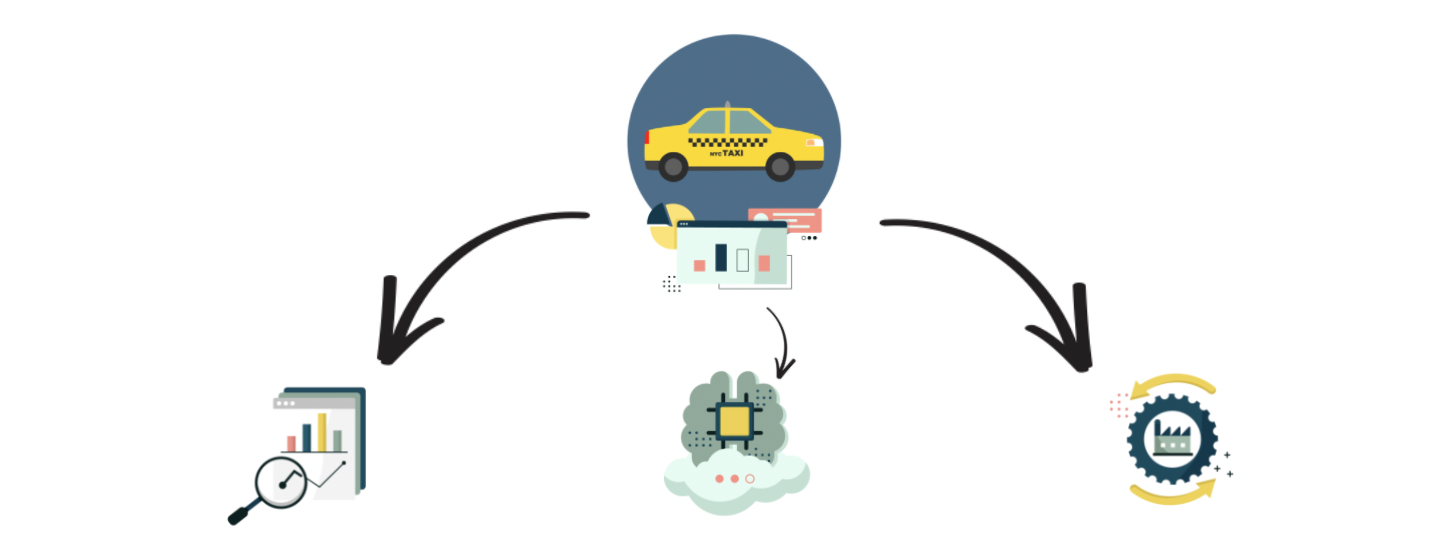

The following is the main sections of this notebook:

**1. Data description, EDA and feature engineering**

In this section, I retrieved the data and explored and analyzed its most important features (columns). I grouped these columns into three categories: 
- location-related columns,
- time-related columns, and
- fare-related columns


Concurrent to this exploration, I also engineered new features that could be useful for the subsequent modeling steps. In addition, I filtered out rows whose entries seemed erroneous or irrelevant for subsequent steps.


**2. Trip analysis**

This section aims to answer the following question:

<font size="2" color = "green">*In which trip groups can you use the groups' mean values as measures of central tendency to estimate fare and duration?*</font>

It is in this section that I categorized the unique trips into "trip groups" and performed statistical analyses on each group to investigate whether or not it is appriate to use the group's mean values as measures of central tendency for fare and duration estimation.


**3. Modeling**


This section aims to answer the following question:

<font size="2" color = "green">*Can we build a model to predict fare and tip amount given pick up and drop off coordinates, time of day and week?*</font>

In this section, I used the features engineered in section 1 to train fare and tip prediction models and analyzed the performance of the models.


**4. Optimization**

In this section, I used the analysis done in section 1 and performed additional analyses to recommend ways NYC taxi drivers and owners to optimize their earnings. Specifically, the following questions will be answered:


- <font size="2" color = "green">*If you were a taxi owner, how would you maximize your earnings in a day?*</font>

- <font size="2" color = "green">*If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?*</font>

- <font size="2" color = "green">*If you run a taxi company with 10 taxis, how would you maximize your earnings?*</font>



# 1. Data retrieval, EDA and feature engineering

## Section summary 

In this section, I retrieved the data from BigQuery and split it into train and test sets.

I only performed the exploration step on the train set, during which I analyzed its most important features (columns). 

I grouped these columns into three categories: location-related columns, time-related columns and fare-related columns, and performed the analysis sequentially for each category.

Concurrent to this exploration, I also engineered new features that either aid the analysis or could be useful for the subsequent modeling steps.

In addition, I filtered out rows whose entries seemed erroneous or irrelevant for subsequent steps.

**Location-related observations and actions**: 
- The majority of the trips start and end in NYC proper. I retricted the coordinates to lie within the boundaries of the greater NYC and its 2 major airports (La Guardia and JFK).
- I engineered two extra Boolean features, `include_jfk` and `include_laguardia` that indicate if a trip originates from/ends at these airports. Around xx% and xx% of the trips have `True` value for `include_jfk` and `include_laguardia`
- I used geohashes to bin the starting and ending coordinates in a rectangular area of size ~600 m x 900 m, and created two additional features, `start_gh` and `end_gh` in the process.
- I assigned each trip into different "trip groups", which is a collection of trips between a specific geohash pairs. I expect that trips within a trip group exhibit some similarity in terms of distance and fare.
- I calculated the `haversine_distance` and the `manhattan_distance` between the pick-up and drop-off points. The mean trip distance calculated using these metrics is around 2 miles, but is much higher for airport trips.
- I removed trips with distance of 0 mile.

**Time-related observations and actions**: 

- I removed trips with a duration of 0 minute
- I investigated how trips are distributed throughout the week and throughout the day. I discovered that most taxi trips take place in the busy hours in the evening.


**Fare-related observations and actions**: 
- I discovered that passangers overwhelmingly pay by either credit card or cash. I removed trips whose payment type is anything but ' Cash' or 'Credit Card' as there are very few of them.
- The majority of trips paid by cash do not involve tips; this might be due to the tipping not being recorded by the cab driver (e.g. to avoid tax). As such, I will exclude rows with cash payment in any future steps that involve the analysis or prediction of tips.
- The median tip for all trips paid using credit cards is USD 2
- The median tip for all `include_jfk` trips paid using credit cards is USD 10



## A. Data Retrieval

I was provided with two csv files: `trip_data.csv` and `trip_data.csv`. I uploaded them as BigQuery tables: `data` and `fare`. Being a cloud data warehouse, BigQuery enables efficient querying and analysis of large datasets like this one.

Within BigQuery, I joined these two tables on the following columns:

- `medallion`: a transferable permit which identifies a unique vehicle
- `_hack_license`: a driver's permit which identifies a unique driver
- `_pickup_datetime`: given a unique combination of medallion and hack license, a pickup time represents a unique taxi trip
    
I selected the most important columns related to the locations, timing and the fees of each trip and randomly sampled around 30,000 rows out of the resulting merged table. 

Finally, I retrieved the query result as a Pandas DataFrame `df`. Each row in df corresponds to a unique taxi trip.


In [2]:
QUERY = """

SELECT data.medallion vehicle_id, 
       data._hack_license driver_id,
       
       data._pickup_datetime start_time,
       data._dropoff_datetime end_time,
       data._trip_time_in_secs duration,
       data._pickup_longitude start_long,
       data._pickup_latitude start_lat,
       data._dropoff_longitude end_long,
       data._dropoff_latitude end_lat,
       data._trip_distance distance,
       
       data._rate_code rate_code,
       fare._total_amount fare,
       fare._tip_amount tip,
       fare._payment_type payment_type
       
       
FROM `meraldo-antonio-sandbox.nyc.trip_data` data
    INNER JOIN `meraldo-antonio-sandbox.nyc.trip_fare` fare
    ON (data.medallion = fare.medallion AND 
        data._pickup_datetime = fare._pickup_datetime AND
        data._hack_license = fare._hack_license)   
    

WHERE MOD(ABS(FARM_FINGERPRINT(CONCAT(data.medallion, data._hack_license, data._pickup_datetime))), 1000) < 2
"""

df = pd.read_gbq(QUERY)

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


In [3]:
print(f"Original shape of the dataframe: {df.shape}")

Original shape of the dataframe: (29726, 14)


In [4]:
df.isna().sum()

vehicle_id      0
driver_id       0
start_time      0
end_time        0
duration        0
start_long      0
start_lat       0
end_long        0
end_lat         0
distance        0
rate_code       0
fare            0
tip             0
payment_type    0
dtype: int64

Let's now drop any rows with missing values.

In [5]:
df.dropna(inplace = True)
print(f"Shape of the dataframe after dropping rows with missing values: {df.shape}")

Shape of the dataframe after dropping rows with missing values: (29726, 14)


Some of the downstream tasks involve model training, which in turn necessitates EDA steps.

Before performing EDA, it's a good practice to first split the data into training/validation set and testing set and only perform the EDA on the training/validation set, so as to avoid any data leakage.

Through the code below, I set aside the 10% of the data as the test set. 

I will perform EDA and model training only on the remaining 90% (the train set).

In [6]:
df, test_df = train_test_split(df, test_size = 0.1, random_state=123)

In [7]:
print(f"Shape of the train/validation set: {df.shape}")

Shape of the train/validation set: (26753, 14)


## B. EDA and feature engineering: location-related columns

In [8]:
# Helper functions

def analyze_numeric_var(var, df, binwidth = 1, var_unit = None):   
    """
    Given a dataframe `df` containing a numeric variable `var`, perform the following:
        - Print out the summary statistics of `var`
        - Draw its distribution
        - Filter out rows in `df` whose values for `var` is less than a certain `min_val` or more than a certain `max_val`
    """
    var_series = df[var]
    var_med = np.median(var_series)
    var_mean = np.mean(var_series)
    
    winsorized_var_series = winsorize(df[var], limits=[0.01, 0.01])
    winsorized_var_med = np.median(winsorized_var_series)
    winsorized_var_mean = np.mean(winsorized_var_series)
    
    print(f"Summary statistics for `{var}`:")
    print(df[var].describe())
    
    (fig, ax) = plt.subplots(2,1, figsize=(15,10))
    ax[0] = sns.histplot(var_series,  ax=ax[0], kde=True, binwidth = binwidth)
    ax[0].axvline(var_med, lw=1.5, ls='dashed', color='black')
    ax[0].axvline(var_mean, lw=1.5, ls='dashed', color='red')
    ax[0].set_xlabel(f"`{var}` (mean: {var_mean:.2f}; median: {var_med:.2f})")
    
    ax[1] = sns.histplot(winsorized_var_series, ax=ax[1], kde=True, binwidth = binwidth)
    ax[1].axvline(winsorized_var_med, lw=1.5, ls='dashed', color='black')
    ax[1].axvline(winsorized_var_mean, lw=1.5, ls='dashed', color='red')
    ax[1].set_xlabel(f'`{var}` with the top/bottom 1% removed (mean: {winsorized_var_mean:.2f}; median: {winsorized_var_med:.2f})')
    if var_unit:
        fig.suptitle(f"Distribution of `{var}` in {var_unit}s")
    else:
        fig.suptitle(f"Distribution of `{var}`")
    plt.show()
    
    
def filter_numeric_var(var, df, min_val):
    """
    Given a dataframe `df` containing a numeric variable `var`, filter out rows in `df` whose values for `var` is less than or equal to a certain `min_val` 
    """  
    print(f"Minimum and maximum values of '{var}' for rows to be included (exclusive): {min_val}")
    print(f"Number of erroneous rows (`{var}` related): {len(df[df[var] <= min_val])}")
    df = df.loc[df[var] > min_val]
    print(f"Shape of the dataframe after filtering out erroneous rows (`{var}` related): {df.shape}\n")
    return df


geolocator = Nominatim(user_agent="ac")
def coord_to_addr(coord_tuple):
    """
    Given a tuple of latitude and longitude, convert it to human-readable address
    """
    coord_str = str(coord_tuple)[1:-1]
    addr = geolocator.reverse(coord_str).address
    short_addr = ",".join(addr.split(",")[:5])
    return short_addr



def manhattan(A, B):
    """  
    Given two coordinates A and B, calculate manhattan distance in km that takes into account the spherical shape of the earth
    """
    elbow_point = (A[0], B[1])
    dist_1 = haversine(A, elbow_point)
    dist_2 = haversine(elbow_point, B)
    manhattan_distance = dist_1 + dist_2
    return manhattan_distance


def analyze_trip_group(trip_group_id, df):
    """
    Given a trip-group-id, perform statistical analysis on it
    """
    assert "fare" in df.columns, "The `fare` column doesn't exist in the provided dataframe!"
    assert "duration" in df.columns, "The `duration` column doesn't exist in the provided dataframe!"
    
    
    _df = df.loc[df["trip_group_id"] == trip_group_id]
    fare = _df["fare"]
    duration = _df["duration"]
    
    fare_med = np.median(fare)
    fare_mean = np.mean(fare)
    
    duration_med = np.median(duration)
    duration_mean = np.mean(duration)
    
    fare_skewness_pval = skewtest(fare)[1]
    duration_skewness_pval = skewtest(duration)[1]
    
    fare_is_skewed = fare_skewness_pval > PVAL_THRESH
    duration_is_skewed = duration_skewness_pval > PVAL_THRESH
    
    
    fig, ax = plt.subplots(2,1, figsize=(15,10))
    ax[0] = sns.histplot(fare,  ax=ax[0], kde=True, binwidth = 1)
    ax[0].axvline(fare_med, lw=1.5, ls='dashed', color='black')
    ax[0].axvline(fare_mean, lw=1.5, ls='dashed', color='red')
    
    if fare_is_skewed:
        ax[0].set_xlabel(f"fare (skewness pval = {fare_skewness_pval:.3f}; is skewed)")
    else:
        ax[0].set_xlabel(f"fare (skewness pval = {fare_skewness_pval:.3f}; is not skewed)")
    
    ax[1] = sns.histplot(duration, ax=ax[1], kde=True, binwidth = 60)
    ax[1].axvline(duration_med, lw=1.5, ls='dashed', color='black')
    ax[1].axvline(duration_mean, lw=1.5, ls='dashed', color='red')
    if duration_is_skewed:
        ax[1].set_xlabel(f'duration (skewness pval = {duration_skewness_pval:.3f}; is skewed)')
    else:
        ax[1].set_xlabel(f"duration (skewness pval = {duration_skewness_pval:.3f}; is not skewed)")
    
    fig.suptitle(f"Distribution of `fare` and `duration` for trip group {str(trip_group_id)}\n median and mean are represented by black and red lines, respectively")
    
    
def mean_error(pred, true):
    return np.mean(pred - true)
    

### Pick-up and drop-off points

First, let's visualize the geographical distribution of the pick-up and drop-off points (for now, we'll treat these two groups together).

I'm interested to see the how many of these points lie within the boundary of greater NYC. I defined this boundary to include NYC proper and its two main airports - John F. Kennedy (JFK) and LaGuardia.

In [9]:
NYC_LAT_LIMITS = (40.62, 40.87)
NYC_LONG_LIMITS = (-74.04, -73.75)

JFK_COORD = (40.65, -73.79)
LAGUARDIA_COORD = (40.7769, -73.8740)

In [10]:
fig=Figure(width=1000,height=600)

# main map
m = folium.Map(
    location=[(NYC_LAT_LIMITS[0] + NYC_LAT_LIMITS[1])/2, (NYC_LONG_LIMITS[0] + NYC_LONG_LIMITS[1])/2],
    zoom_start=11,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False
)

# add NYC bound
bounds = [(NYC_LAT_LIMITS[0], NYC_LONG_LIMITS[0]),
          (NYC_LAT_LIMITS[1], NYC_LONG_LIMITS[0]),
          (NYC_LAT_LIMITS[0], NYC_LONG_LIMITS[1]),
          (NYC_LAT_LIMITS[1], NYC_LONG_LIMITS[1])]
folium.Rectangle(bounds=bounds, color="#572a27", fill=True, fill_color="#f2e1f1", fill_opacity=0.5).add_to(m)

# add cluster points
coordinate_list = df[["start_lat", "start_long"]].values.tolist() + df[["end_lat", "end_long"]].values.tolist() 
m.add_child(FastMarkerCluster(coordinate_list))

# add LaGuardia in black
folium.Marker(popup = "La Guardia", location=[LAGUARDIA_COORD[0], LAGUARDIA_COORD[1]], icon=folium.Icon(color='black', icon='plane', prefix='fa')).add_to(m)

# add JFK in red
folium.Marker(popup = "JFK", location=[JFK_COORD[0], JFK_COORD[1]], icon=folium.Icon(color='red', icon='plane', prefix='fa')).add_to(m)

fig.add_child(m)

We see above that there some trips that either originate from or end in places that fall outside of this boundary. Let's filter out these trips.

In [11]:
df = df.loc[(df.start_lat >= NYC_LAT_LIMITS[0]) & (df.start_lat <= NYC_LAT_LIMITS[1])]
df = df.loc[(df.end_lat >= NYC_LAT_LIMITS[0]) & (df.end_lat <= NYC_LAT_LIMITS[1])]
df = df.loc[(df.start_long >= NYC_LONG_LIMITS[0]) & (df.start_long <= NYC_LONG_LIMITS[1])]
df = df.loc[(df.end_long >= NYC_LONG_LIMITS[0]) & (df.end_long <= NYC_LONG_LIMITS[1])]
print(f"Shape of the dataframe after filtering out out-of-bound data points: {df.shape}")

Shape of the dataframe after filtering out out-of-bound data points: (26134, 14)


### Airport trips

Trips to the airports might have distrinct fare and tip distributions then non-airport trips.

As such, here, I will engineer new Boolean features called `involve_jfk` and `involve_laguardia` which indicates whether or not a person is travelling to or from the JFK/La Guardia airports. 

The values of these features will be `True` if the *haversine* distance between the pick-up/drop-off points of a trip fall under a preset radius from either of the two airports.

In [12]:
MAX_DISTANCE_METER = 3000 # max distance from the midpoint of the JFK airport in meters (JFK is huge so the radius is big)
max_distance_mile = MAX_DISTANCE_METER * 0.000621371

MAX_DISTANCE_METER_LAGUARDIA = 1500 # max distance from the midpoint of the La Guardia airport in meters 
max_distance_mile_laguardia = MAX_DISTANCE_METER_LAGUARDIA * 0.000621371



In [13]:
df["include_JFK"] = df.apply(lambda x: 
                             (haversine((x.start_lat, x.start_long), JFK_COORD) <= max_distance_mile) or 
                             (haversine(JFK_COORD, (x.end_lat, x.end_long)) <= max_distance_mile), axis = 1)

df["include_laguardia"] = df.apply(lambda x: 
                             (haversine((x.start_lat, x.start_long), LAGUARDIA_COORD) <= max_distance_mile_laguardia) or 
                             (haversine(LAGUARDIA_COORD, (x.end_lat, x.end_long)) <= max_distance_mile_laguardia), axis = 1)


Let's take a look at some trips whose value for `include_laguardia` is `True`.

In [14]:

fig=Figure(width=1000,height=600)
m = folium.Map(
    location=LAGUARDIA_COORD,
    zoom_start=12,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False

)


folium.Circle([LAGUARDIA_COORD[0], LAGUARDIA_COORD[1]],
              radius=MAX_DISTANCE_METER_LAGUARDIA, 
              color="#572a27", 
              fill=True, 
              fill_color="#f2e1f1", 
              fill_opacity=0.5
                   ).add_to(m)



#add lines
TOP_N = 5
for idx, row in df[df["include_laguardia"] == True].head(TOP_N).iterrows():
    start_addr = coord_to_addr((row["start_lat"],row["start_long"] ))
    end_addr = coord_to_addr((row["end_lat"],row["end_long"] ))
    points = [(row["start_lat"],row["start_long"] ), (row["end_lat"],row["end_long"] )]
    folium.PolyLine(points, 
                    weight=2, 
                    opacity=1, 
                    tooltip = str(idx) + ") " + start_addr + " -- " + end_addr).add_to(m)


fig.add_child(m)



### Binning pick-up and drop-off points with geohashing

For the subsequent sections, it will be useful to group together these pick-up and drop-off points in a logical way. To that end, I used [geohashes](https://en.wikipedia.org/wiki/Geohash). 

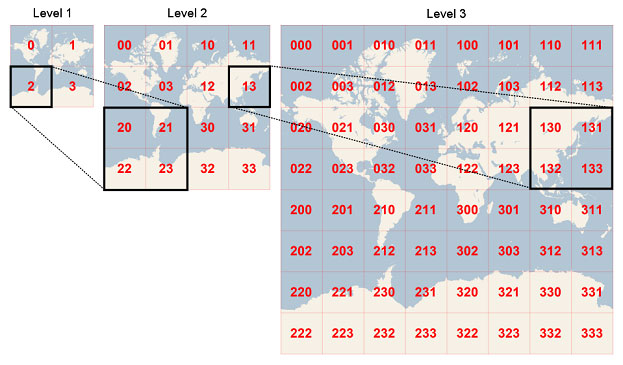

Geohashes refer to a hierarchical spatial data structure which subdivides the earth's surface into grids. The size of the grid is adjustable: longer geohashes (i.e. those whose string representations contain more characters) are associated with finer grids.

I used geohashes with a precision of 6, which corresponds to a grid with a height of ~600 m and longitudinal length of ~ 900 m. Such a grid would include around 20 blocks in Manhattan and roughly correspond to a small neighborhood in NYC (e.g. SoHo). At any given time, the local traffic condition within this grid can be assumed to be uniform.


Let's visualize an example of such geohash:


In [15]:
GEOHASH_EXAMPLE = "dr5ru7" # an example geohash with precision 6 corresponding to central Manhattan
gh_limits = gh.bbox(GEOHASH_EXAMPLE ) 
bounds = [(gh_limits["n"], gh_limits["w"]),
          (gh_limits["s"], gh_limits["w"]),
          (gh_limits["n"], gh_limits["e"]),
          (gh_limits["s"], gh_limits["e"])]

print(f"Dimension of the geohash `{GEOHASH_EXAMPLE}`")
print(f'Longitudinal length : {haversine((gh_limits["s"], gh_limits["e"]), (gh_limits["s"], gh_limits["w"])) :.3} km')
print(f'Height : {haversine((gh_limits["n"], gh_limits["w"]), (gh_limits["s"], gh_limits["w"])) :.3} km')

Dimension of the geohash `dr5ru7`
Longitudinal length : 0.925 km
Height : 0.611 km


In [16]:
# main map
fig=Figure(width=1000,height=600)
m = folium.Map(
    location=[(gh_limits["n"] + gh_limits["s"])/2, (gh_limits["w"] + gh_limits["e"])/2],
    zoom_start=15,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False

)

folium.Rectangle(bounds=bounds, color="#572a27", fill=True, fill_color="#f2e1f1", fill_opacity=0.5).add_to(m)
fig.add_child(m)


Let's now find the geohashes corresponding to the pick-up and drop-off locations in the dataset. These geohashes are termed `start_gh` and `end_gh`, respectively. 

In [17]:
GH_PRECISION = 6 
df["start_gh"] = df.apply(lambda x: gh.encode(x.start_lat, x.start_long, precision = GH_PRECISION), axis = 1)
df["end_gh"] = df.apply(lambda x: gh.encode(x.end_lat, x.end_long, precision = GH_PRECISION), axis = 1)

The following is the total number of unique geohashes in the dataset:

In [18]:
pd.concat([df["start_gh"], df["end_gh"]], axis = 0).nunique()

558

### Trip groups

Using this geohashes, we can logically group the trips together.

A "trip group" is a collection of trips that share the same origin geohash and ending geohash (the starting and ending geohashes can be the same for short trips). I expect that the trips within each trip group to show some similarity in terms of distance and fare.

We will now engineer another column, `trip_group_id`, that identifies the trip group to which a trip belong. We will use this `trip_group_id` column extensively in section 2.

In [19]:
df["trip_group_id"] = df.apply(lambda x: tuple({x.start_gh, x.end_gh}) if x.start_gh != x.end_gh else (x.start_gh, x.end_gh)
                                                                , axis = 1)

# string equivalent as tuples are not hashable
df["trip_group_id_str"] = df.apply(lambda x: str(x["trip_group_id"][1:-1]), axis = 1)

The following is the total number of `trip_group_id`'s in the dataset.

In [20]:
df["trip_group_id"].nunique()

5758

### Distance

The dataset contains a variable called `distance`; however, it is rather unclear what exact distance this refers to.

The variable's name suggests that it refers to the real distance recorded by the taxi's odometer in each trip; however, we'll see in a bit that this proposed definition might not be correct.

In any case, let's now investigate the distribution of the `distance` variable.

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `distance`:
count    26134.000000
mean         2.820725
std          3.185360
min          0.000000
25%          1.080000
50%          1.790000
75%          3.200000
max         39.200000
Name: distance, dtype: float64


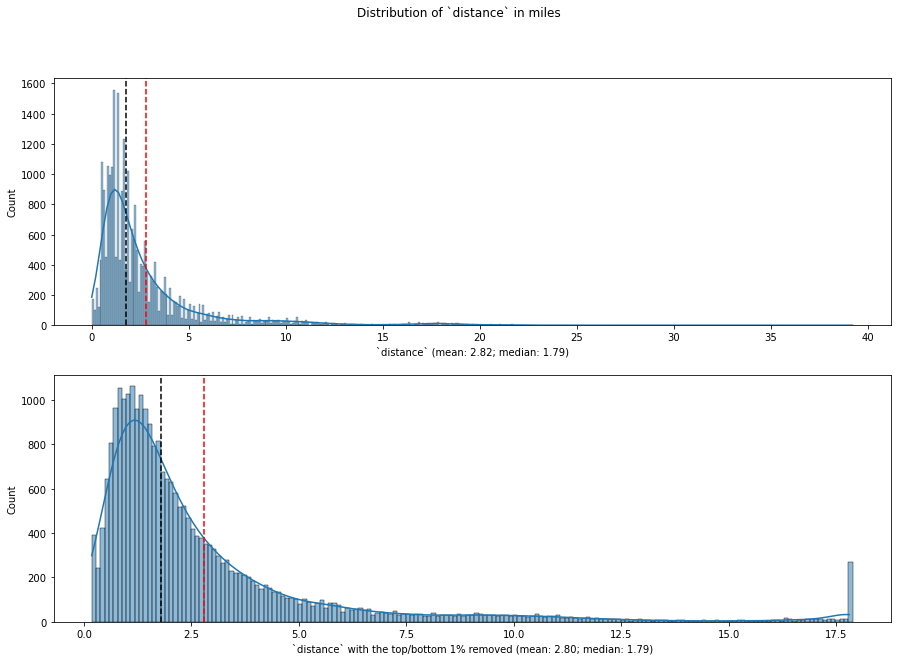

In [21]:
analyze_numeric_var(var = "distance", 
                    df = df, 
                    binwidth = 0.1,
                    var_unit = "mile")

Notwithstanding the true definition of this `distance` variable, do note that it cannot be used as a predictor in the modeling step (section 3), in which only features **directly derived** from pick-up/drop-off locations are permitted.

As such, we will need to approximate the distance covered in each trip by engineering new "distance" features. Here are some ideas as to what distance features can be created:
  1. Haversine distance: a metric that represents the shortest distance between two points on a sphere using their latitudes and longitudes
  2. Manhattan distance: a metric that measures the distance between two points measured along axes at right angles
  3. Real-world driving distance: a driving distance that results from using third-party sources (e.g. Google Maps API) to approximate real-world driving distance between two addresses.
  
The diagram below shows how these three distance metrics look like for a trip between central Manhattan and JFK.


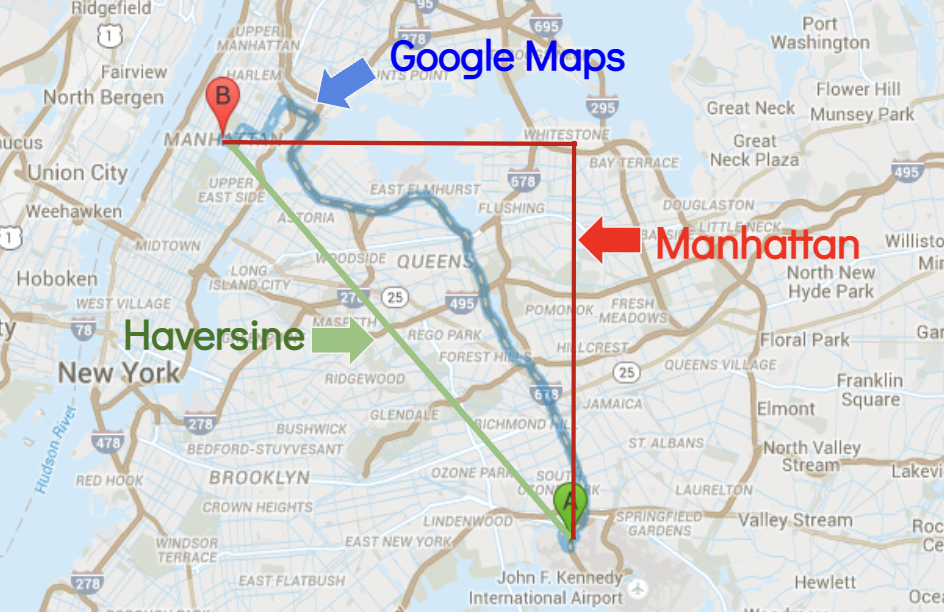



In this exercise, I will engineer and analyze the Haversine and Manhattan distances. Real-world driving distance will not be used because unfortunately, engineering this feature (e.g. by invoking the Google Maps API) might incur some cost. However, in real-world application, this third metric might prove to be the most accurate.


In [22]:
df["haversine_distance"] = df.apply(lambda x: haversine((x.start_lat, x.start_long), (x.end_lat, x.end_long)), axis = 1)
df["manhattan_distance"] = df.apply(lambda x: manhattan((x.start_lat, x.start_long), (x.end_lat, x.end_long)), axis = 1)

Here, we see how the original `distance` variable compares with the newly engineered `haversine_distance` and `manhattan_distance`.

In [23]:
df[["distance", "haversine_distance", "manhattan_distance"]].head()

distance  haversine_distance  manhattan_distance
4974       2.98            4.439656            6.141088
12894      0.53            0.776150            1.056468
12780      0.76            0.587844            0.618506
9688       2.11            2.483310            3.365021
3699       1.99            2.573396            3.417692

Surprisingly the original `distance` variable consistently exceeds the `haversine_distance`, which is by definition the shortest distance between two points. This calls into question the validity of the original `distance` variable.


Let's now explore the distributions of `haversine_distance` for:

- (1) the whole training dataset
- (2) JFK-trips
- (3) LaGuardia-trips

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `haversine_distance`:
count    26134.000000
mean         3.323310
std          3.477662
min          0.000000
25%          1.292089
50%          2.201858
75%          3.978887
max         27.302133
Name: haversine_distance, dtype: float64


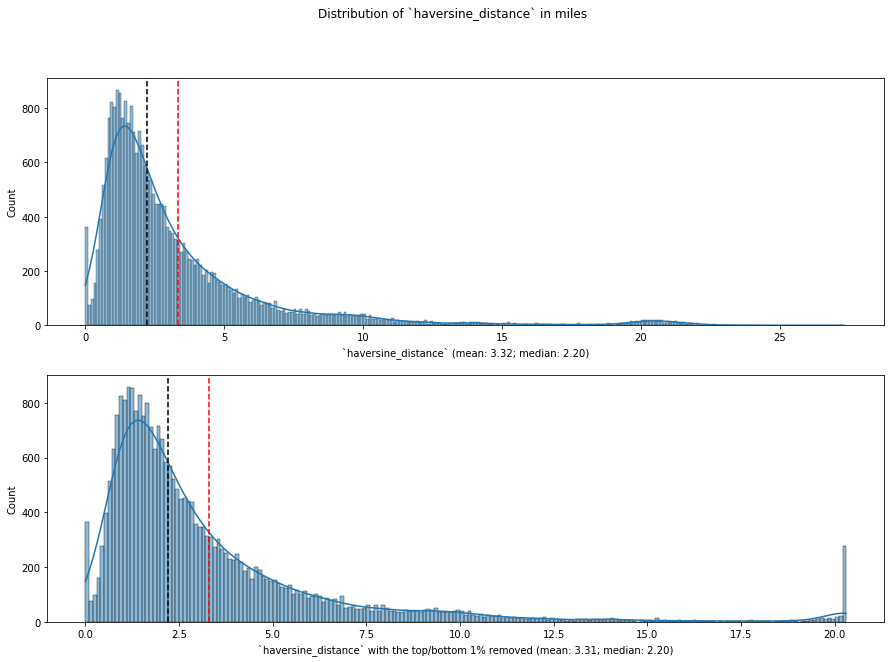

In [24]:
analyze_numeric_var(var = "haversine_distance", 
                    df = df, 
                    binwidth = 0.1,
                    var_unit = "mile")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `haversine_distance`:
count    571.000000
mean      18.406995
std        4.861862
min        0.000000
25%       17.887601
50%       20.170862
75%       20.979602
max       27.302133
Name: haversine_distance, dtype: float64


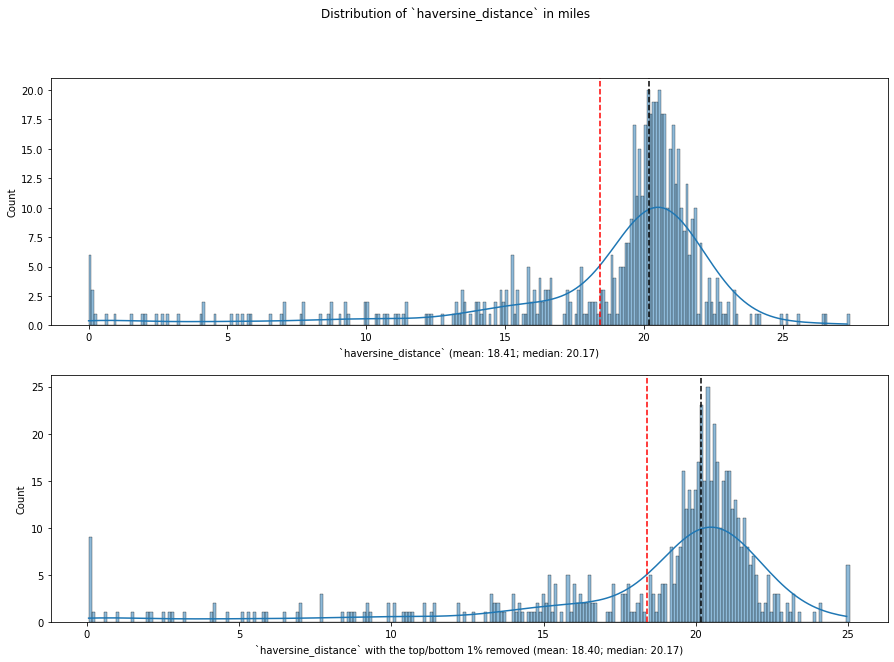

In [25]:
analyze_numeric_var(var = "haversine_distance", 
                    df = df[df["include_JFK"] == True], 
                    binwidth = 0.1,
                    var_unit = "mile")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `haversine_distance`:
count    457.000000
mean       9.394607
std        2.700733
min        0.000000
25%        8.287457
50%        9.420275
75%       10.724260
max       17.233312
Name: haversine_distance, dtype: float64


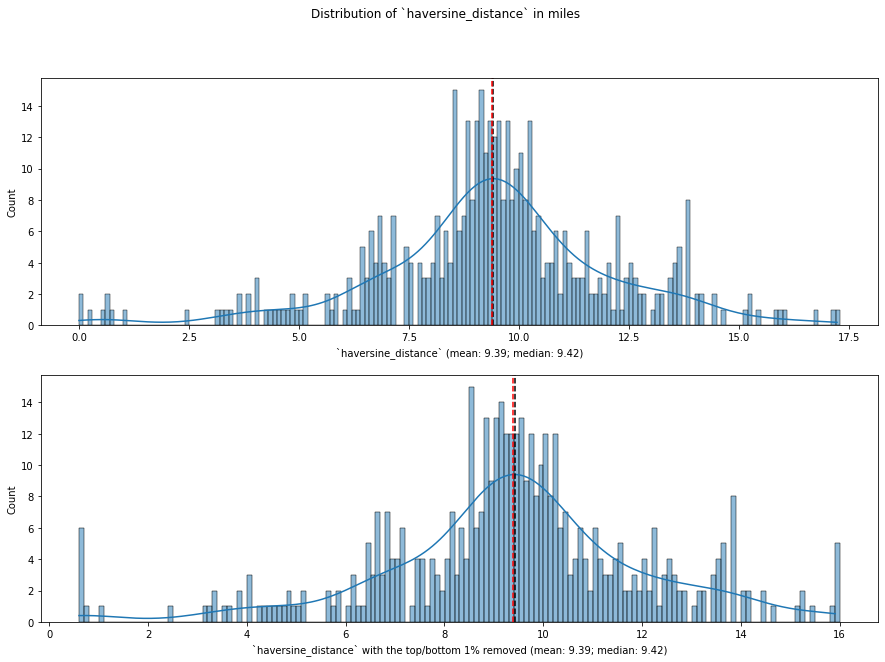

In [26]:
analyze_numeric_var(var = "haversine_distance", 
                    df = df[df["include_laguardia"] == True], 
                    binwidth = 0.1,
                    var_unit = "mile")

We see that the median `haversine_distance` is as follows:
- all trips: ~2.2 miles
- JFK trips: ~20.0 miles
- LaGuardia trips: ~9.3 miles

These values make sense considering most of the trips originate from/end in the city centre and the airport trips involve driving from the city centre to the outskirts. 


Now let's do the same analysis for `manhattan_distance`:

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `manhattan_distance`:
count    26134.000000
mean         4.286880
std          4.620406
min          0.000000
25%          1.648753
50%          2.831998
75%          5.125525
max         36.620213
Name: manhattan_distance, dtype: float64


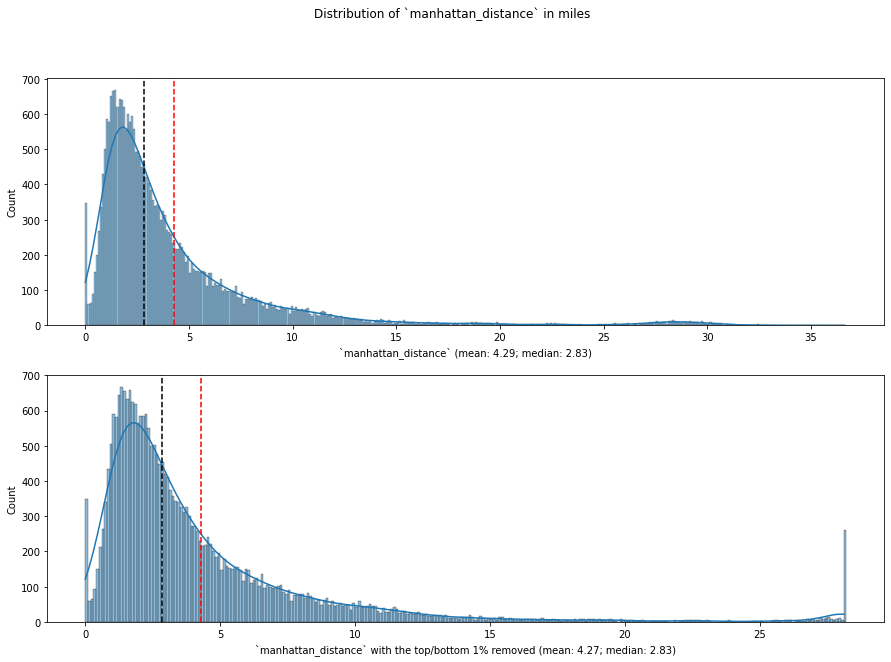

In [27]:
analyze_numeric_var(var = "manhattan_distance", 
                    df = df, 
                    binwidth = 0.1,
                    var_unit = "mile")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `manhattan_distance`:
count    571.000000
mean      25.072850
std        7.085701
min        0.000000
25%       22.942286
50%       27.806991
75%       29.191206
max       36.620213
Name: manhattan_distance, dtype: float64


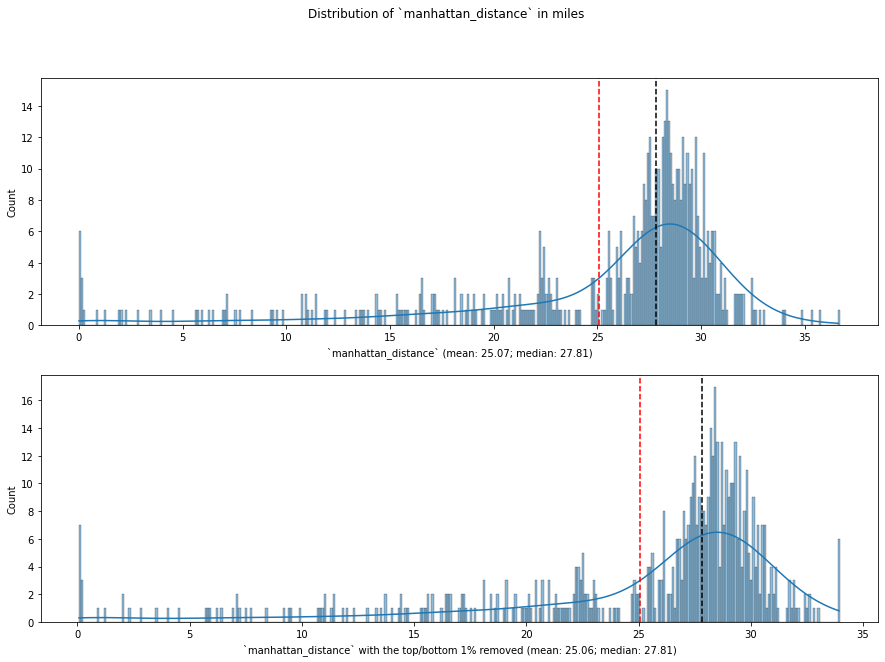

In [28]:
analyze_numeric_var(var = "manhattan_distance", 
                    df = df[df["include_JFK"] == True], 
                    binwidth = 0.1,
                    var_unit = "mile")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `manhattan_distance`:
count    457.000000
mean      11.727270
std        4.016071
min        0.000000
25%        9.715849
50%       11.139220
75%       13.962166
max       23.857614
Name: manhattan_distance, dtype: float64


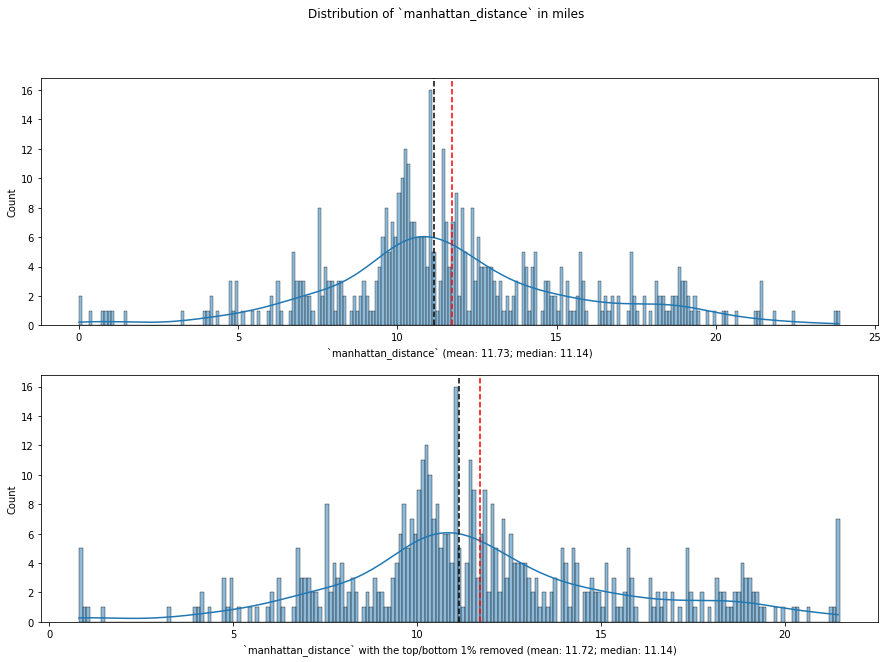

In [29]:
analyze_numeric_var(var = "manhattan_distance", 
                    df = df[df["include_laguardia"] == True], 
                    binwidth = 0.1,
                    var_unit = "mile")

We see that the median `manhattan_distance` is as follows:
- all trips: ~2.8 miles
- JFK trips: ~27.7 miles
- LaGuardia trips: ~11.2 miles

We see that these `manhattan_distance`s are longer than `haversine_distance`s, which is expected.

We also see that there are some trips for which the distance is 0 mile in all three distance metrics. Trips of 0 mile are not logically possible and might stem from erroneous data entry. Let's remove the rows with 0 distance.

In [30]:
df = filter_numeric_var("distance", df,  0)
df = filter_numeric_var("haversine_distance", df,  0)
df = filter_numeric_var("manhattan_distance", df,  0)

Minimum and maximum values of 'distance' for rows to be included (exclusive): 0
Number of erroneous rows (`distance` related): 137
Shape of the dataframe after filtering out erroneous rows (`distance` related): (25997, 22)

Minimum and maximum values of 'haversine_distance' for rows to be included (exclusive): 0
Number of erroneous rows (`haversine_distance` related): 207
Shape of the dataframe after filtering out erroneous rows (`haversine_distance` related): (25790, 22)

Minimum and maximum values of 'manhattan_distance' for rows to be included (exclusive): 0
Number of erroneous rows (`manhattan_distance` related): 0
Shape of the dataframe after filtering out erroneous rows (`manhattan_distance` related): (25790, 22)



## C. EDA and feature engineering: time-related columns

### Duration

Let's now investigate the distribution of the `duration` for all trips, JFK-trips and LaGuardia trips.

Summary statistics for `duration`:
count    25790.000000
mean       751.730593
std        535.889101
min          0.000000
25%        371.000000
50%        602.000000
75%        965.000000
max       5592.000000
Name: duration, dtype: float64


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


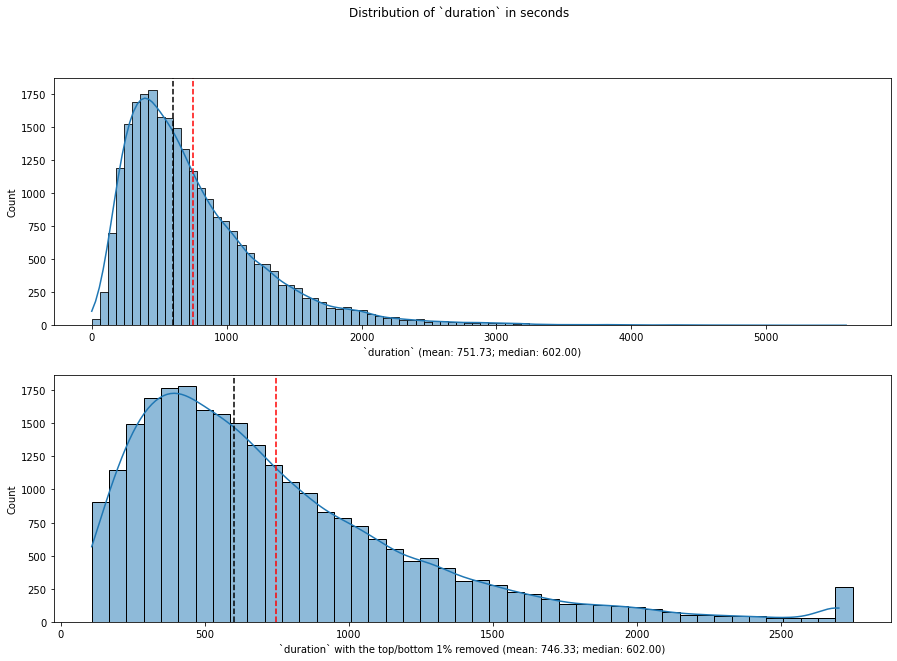

In [31]:
analyze_numeric_var(var = "duration", 
                    df = df, 
                    binwidth = 60,
                    var_unit = "second")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `duration`:
count     561.000000
mean     2252.586453
std       927.398587
min         3.000000
25%      1654.000000
50%      2100.000000
75%      2815.000000
max      5592.000000
Name: duration, dtype: float64


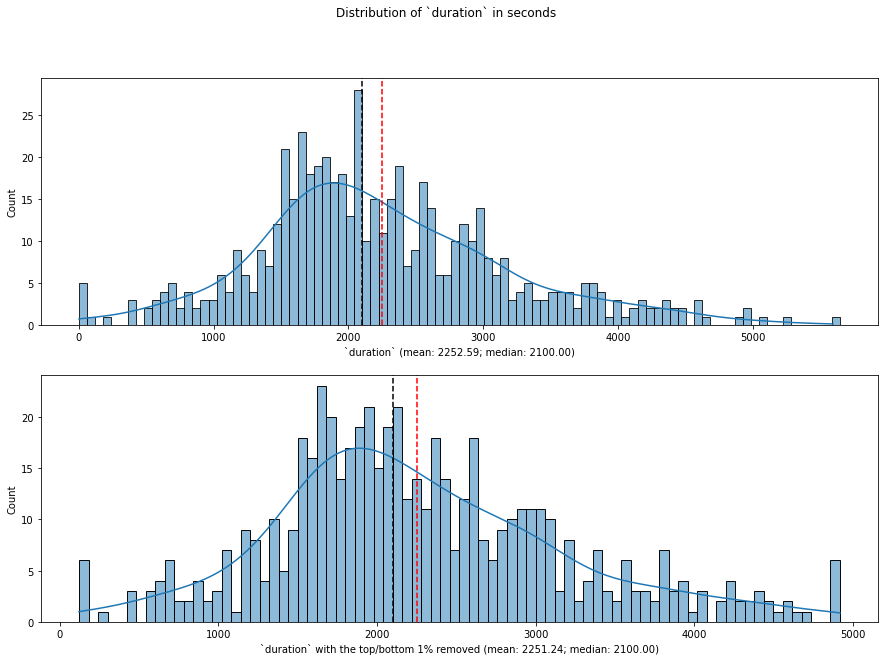

In [32]:
analyze_numeric_var(var = "duration", 
                    df = df[df["include_JFK"] == True], 
                    binwidth = 60,
                    var_unit = "second")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `duration`:
count     454.000000
mean     1415.803965
std       532.218228
min       180.000000
25%      1065.750000
50%      1352.500000
75%      1732.000000
max      3576.000000
Name: duration, dtype: float64


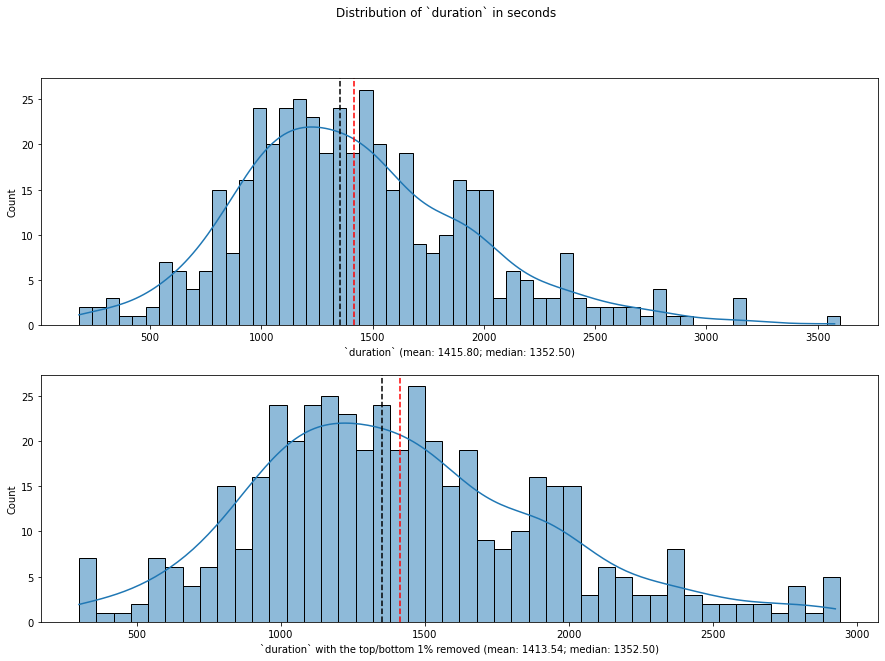

In [33]:
analyze_numeric_var(var = "duration", 
                    df = df[df["include_laguardia"] == True], 
                    binwidth = 60,
                    var_unit = "second")

We see that the median `duration` is as follows:
- all trips: ~ 600 seconds
- JFK trips: ~ 2100 seconds
- LaGuardia trips: ~ 1300 seconds

These values make sense given the relative distances of these airports to the city centre.

There are also some rows whose `duration` value is 0, which is not physically possible. Let's remove these rows:

In [34]:
df = filter_numeric_var("duration", df,  0)

Minimum and maximum values of 'duration' for rows to be included (exclusive): 0
Number of erroneous rows (`duration` related): 12
Shape of the dataframe after filtering out erroneous rows (`duration` related): (25778, 22)



### Time of trip

The dataset contains the `start_time` column which is useful but is too fine-grained for subsequent analyses.

Here, I engineer several derivative time features by binning `start_time` into coarser buckets (hour and day). I also crossing the resulting binned features together.

First, I simply extracted the hour and the day from the start time:

In [35]:
df["start_hour"] = df["start_time"].dt.hour
df["day"] = df["start_time"].dt.day_name()

Let's now create a heatmap to understand how **pick-up activites** vary between different days/hours.

Text(0.5, 1.0, 'Number of trips in each hour/day combination')

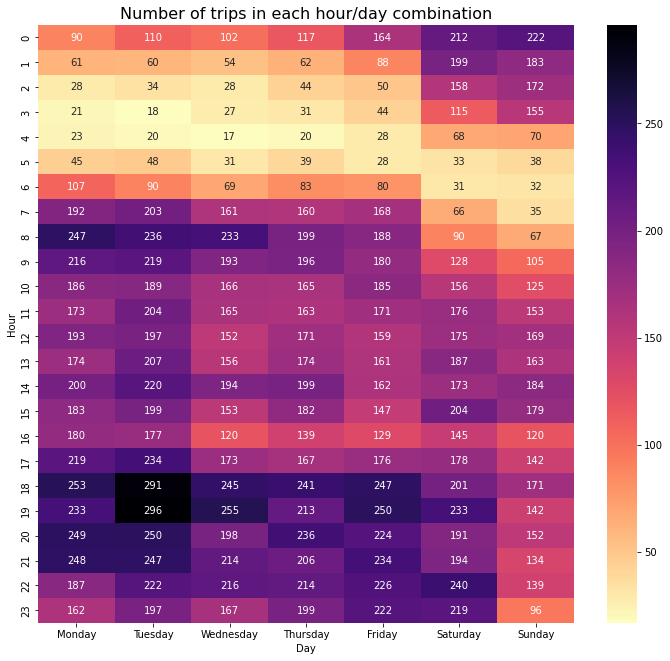

In [36]:
DAYS = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

time_grouped_df = df.groupby(['day','start_hour']).size().reset_index()
time_grouped_piv_df = pd.pivot_table(time_grouped_df, values=0,index=["start_hour"], columns=["day"], fill_value=0)
time_grouped_piv_df = time_grouped_piv_df[DAYS]

heatmap_activity, ax = plt.subplots(figsize=(12,11))
ax = sns.heatmap(time_grouped_piv_df, ax=ax, cmap='magma_r', annot=True, fmt="d")
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Hour', fontsize=10)
ax.set_title('Number of trips in each hour/day combination', fontsize=16)


We observe in the above heatmap that evenings from Monday to Saturday appear to be the busiest time, which most cabs being hailed at 7 pm. 

On the other hamd, on weekdays, only few trips happen during the early morning hours between 1 am and 5 am.


Let's create another heatmap to investigate if **average total fares** vary between each days/hours.

Text(0.5, 1.0, 'Average fare in each hour/day combination')

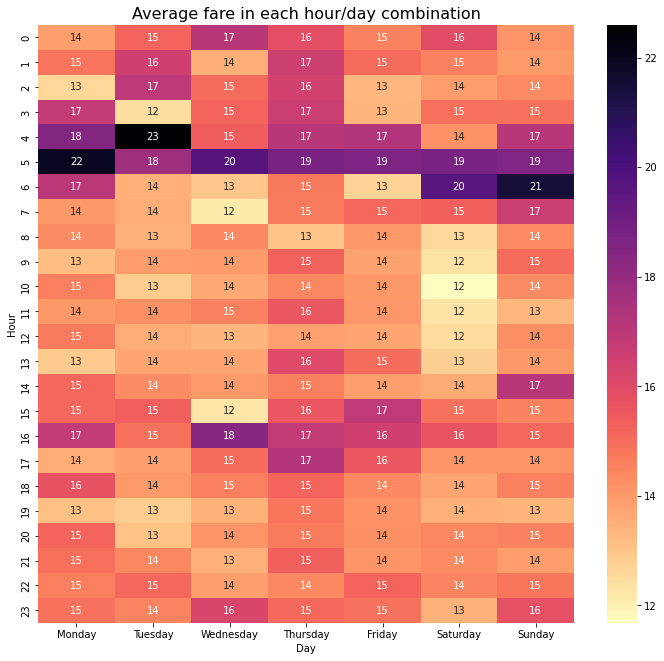

In [37]:
time_grouped_df = df.groupby(['day','start_hour'])['fare'].mean().reset_index()
time_grouped_piv_df = pd.pivot_table(time_grouped_df, values='fare',index=["start_hour"], columns=["day"], fill_value=0)
time_grouped_piv_df = time_grouped_piv_df[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

heatmap_average_fare, ax = plt.subplots(figsize=(12,11))
ax = sns.heatmap(time_grouped_piv_df, ax=ax, cmap='magma_r', annot=True)
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Hour', fontsize=10)
ax.set_title('Average fare in each hour/day combination', fontsize=16)

From the heatmap above, we see that the early morning weekday trips (between 4 to 6 am) command the highest fare. 

Since there seems to be a strong interaction between the `day` and `start_hour` variable, I will create another feature, `day_start_hour` by feature-crossing the two.

In [38]:
df["day_start_hour"] = df["day"].str.cat(df["start_hour"].astype(str), sep = " - ")

Let's now see how these time features relate to one another:

In [39]:
df[["start_time", "start_hour", "day", "day_start_hour"]].head()

start_time  start_hour        day day_start_hour
4974  2013-04-18 08:33:00+00:00           8   Thursday   Thursday - 8
12894 2013-04-10 07:40:00+00:00           7  Wednesday  Wednesday - 7
12780 2013-04-15 10:15:00+00:00          10     Monday    Monday - 10
9688  2013-04-25 18:21:00+00:00          18   Thursday  Thursday - 18
3699  2013-04-20 13:50:00+00:00          13   Saturday  Saturday - 13

## D. EDA and feature engineering: payment-related columns

### Fare

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `fare`:
count    25778.000000
mean        14.489435
std         10.859888
min          3.000000
25%          8.000000
50%         11.050000
75%         16.500000
max        130.250000
Name: fare, dtype: float64


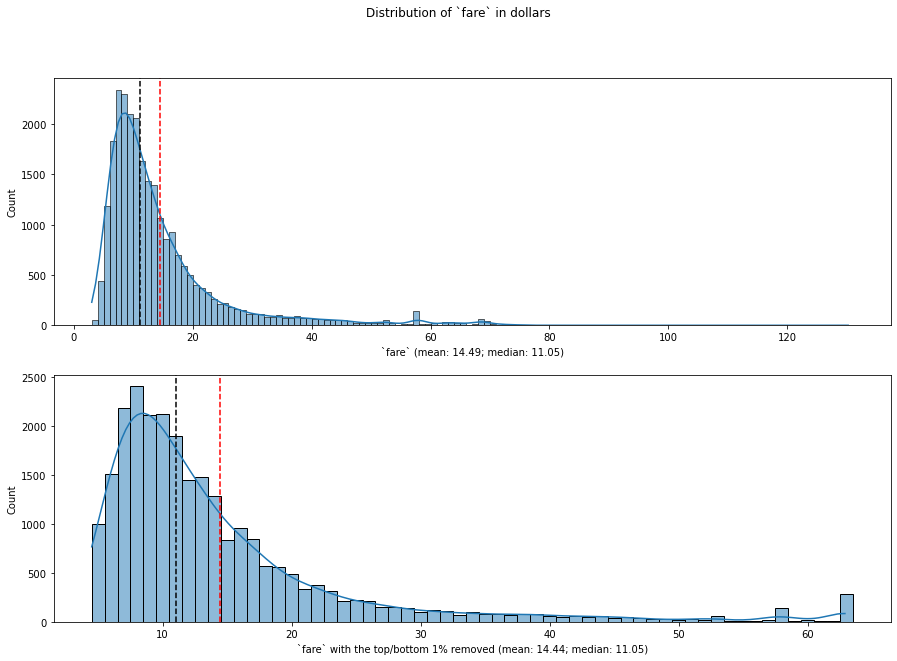

In [40]:
analyze_numeric_var(var = "fare", 
                    df = df, 
                    binwidth = 1,
                    var_unit = "dollar")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `fare`:
count    561.000000
mean      56.835276
std       14.231683
min        5.000000
25%       52.500000
50%       57.830000
75%       67.830000
max      122.830000
Name: fare, dtype: float64


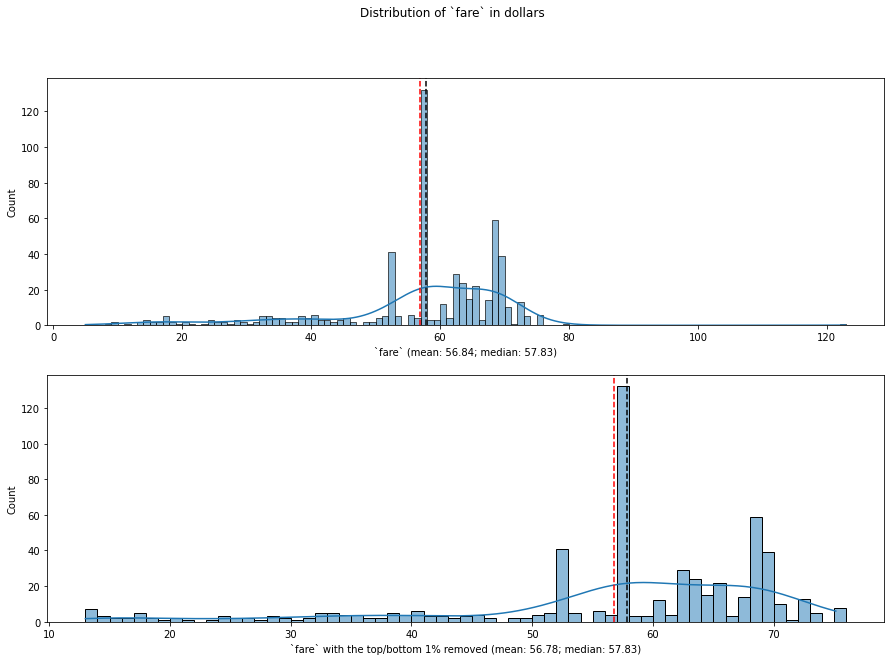

In [41]:
analyze_numeric_var(var = "fare", 
                    df = df[df["include_JFK"] == True], 
                    binwidth = 1,
                    var_unit = "dollar")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `fare`:
count    454.00000
mean      37.45130
std       10.50173
min        6.00000
25%       32.50000
50%       37.94000
75%       42.99000
max      112.28000
Name: fare, dtype: float64


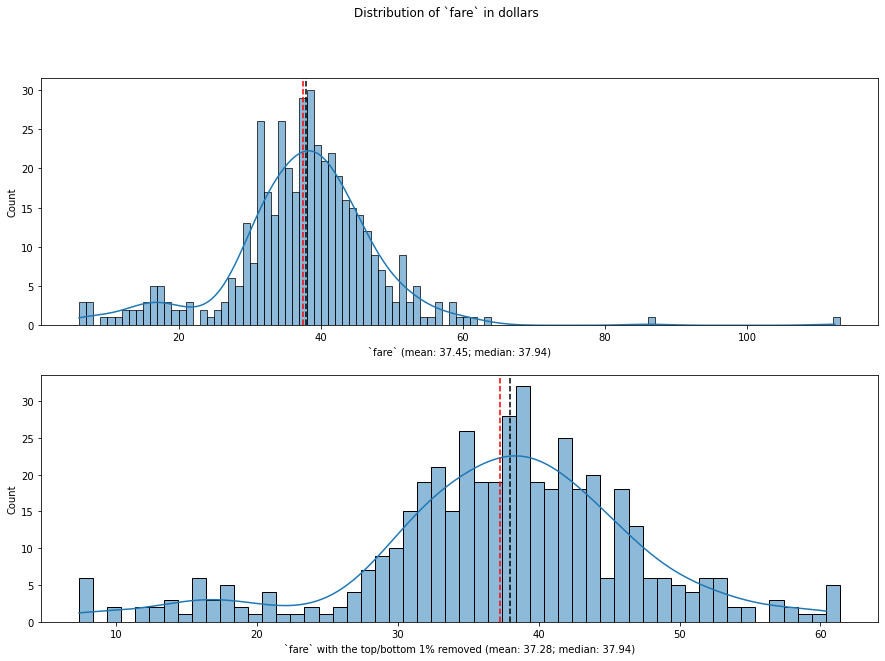

In [42]:
analyze_numeric_var(var = "fare", 
                    df = df[df["include_laguardia"] == True], 
                    binwidth = 1,
                    var_unit = "dollar")

We see that the the median fare for all trips is around USD 11, whereas the median fare for JFK and LaGuardia trips are USD 57 and USD 39, respectively.

#### Payment type

Let's see if there is a difference in tips between payment types

In [43]:
print("Percentages of trip paid using different payment types:")
df["payment_type"].value_counts()/len(df)*100

Percentages of trip paid using different payment types:


CRD    53.890915
CSH    45.845294
NOC     0.186205
DIS     0.050431
UNK     0.027155
Name: payment_type, dtype: float64

We see that passangers overwhelmingly pay using either cash or card. Let's restrict our dataframe to only include trips paid using these payment types.

In [44]:
df = df.loc[df["payment_type"].isin(["CSH","CRD"])]

#### Rate code

According to the [website](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) of the NYC municipal government, each taxi trip can be of one of the following rate codes:

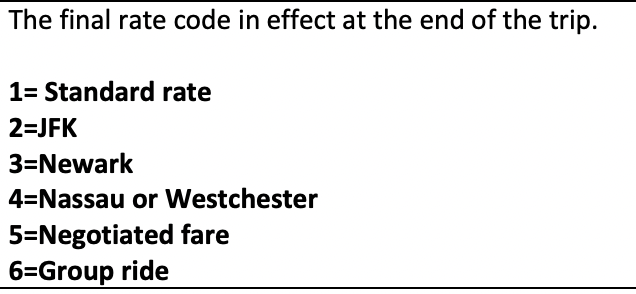

Let's now investigate the distribution.

In [45]:
print("Percentages of trip having different rate codes:")
df["rate_code"].value_counts()/len(df)*1001

Percentages of trip having different rate codes:


1    982.817697
2     16.624932
5      0.817620
4      0.661883
3      0.038934
0      0.038934
Name: rate_code, dtype: float64

We see that most trips are paid using standard rate, and that some trips that involve JFK are paid using different rate system.

The trips to far-flung suburbs/neighboring towns only occupy a minority of our data.

Let's filter out trips that don't have rate code of either 1 or 2.

In [46]:
df = df.loc[df["rate_code"].isin([1,2])]

#### Tips

First, let's see the overall distribution of tip for all trips.

Summary statistics for `tip`:
count    25670.000000
mean         1.343023
std          2.065285
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         65.000000
Name: tip, dtype: float64


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


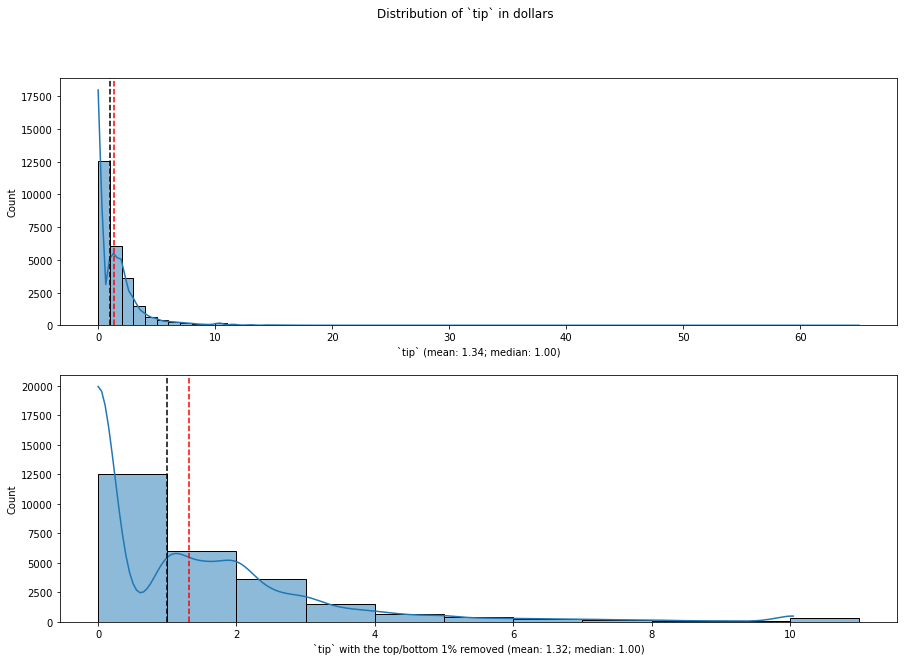

In [47]:
analyze_numeric_var(var = "tip", 
                    df = df, 
                    binwidth = 1,
                    var_unit = "dollar")

We see that the median tip is only USD 1, which is suspiciously low. Could it be that some of the drivers do not report the tips they received to avoid paying taxes? Such omission is possible only when the fare is paid in cash. 


Let's take a closer look at the tips for the trips paid in cash:

In [48]:
len(df.loc[(df["payment_type"] == "CSH") & (df["tip"] == 0)])/len(df.loc[df["payment_type"] == "CSH"])

1.0

Our suspicion is confirmed - nearly **all** of these trips record a tip value of zero! 

Let's now see the tip distribution for all trips paid by credit card:

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `tip`:
count    13867.000000
mean         2.486148
std          2.248113
min          0.000000
25%          1.200000
50%          2.000000
75%          2.900000
max         65.000000
Name: tip, dtype: float64


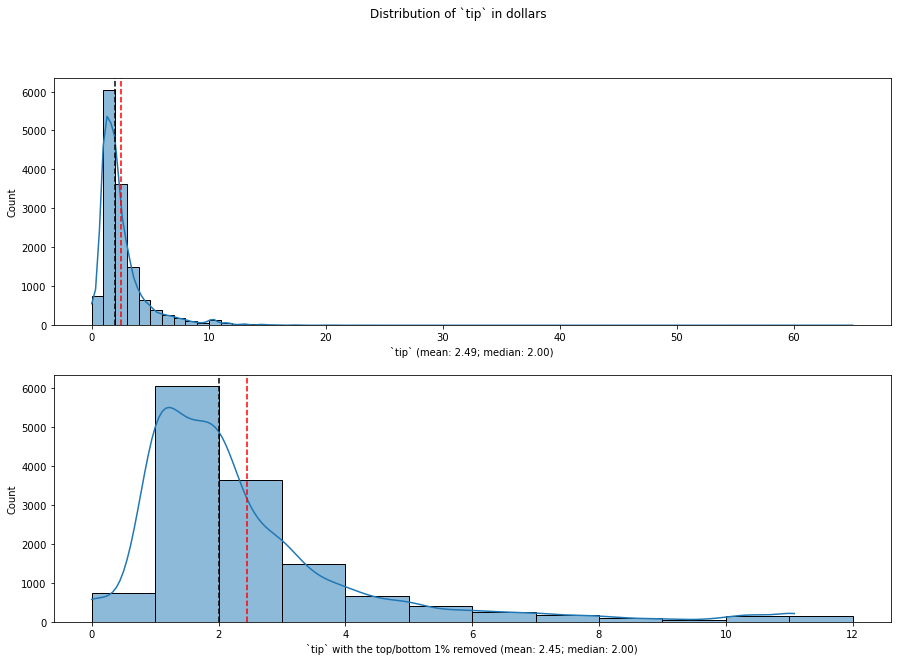

In [49]:
analyze_numeric_var(var = "tip", 
                    df = df.loc[df["payment_type"] == "CRD"], 
                    binwidth = 1,
                    var_unit = "dollar")

Now we see that the median tip is a more respectable USD 2, around 15% of the median fare of USD 11.

With this observation in mind, going forward, whenever performing any analysis or predicition involving tips, I will only use trips paid using credit cards.

Let's see how the distribution of tips differ for trips involving the airports:

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `tip`:
count    304.000000
mean       9.750691
std        4.933291
min        0.000000
25%        7.875000
50%       10.400000
75%       11.560000
max       65.000000
Name: tip, dtype: float64


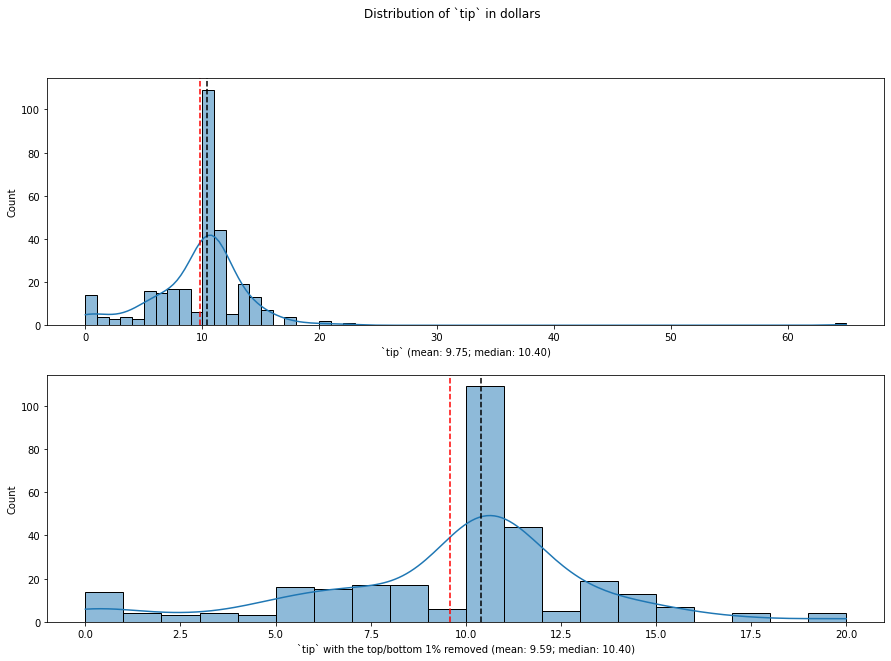

In [50]:
analyze_numeric_var(var = "tip", 
                    df = df.loc[(df["payment_type"] == "CRD") & (df["include_JFK"] == True)], 
                    binwidth = 1,
                    var_unit = "dollar")

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Summary statistics for `tip`:
count    288.000000
mean       6.143958
std        3.745533
min        0.000000
25%        4.875000
50%        6.400000
75%        7.660000
max       50.000000
Name: tip, dtype: float64


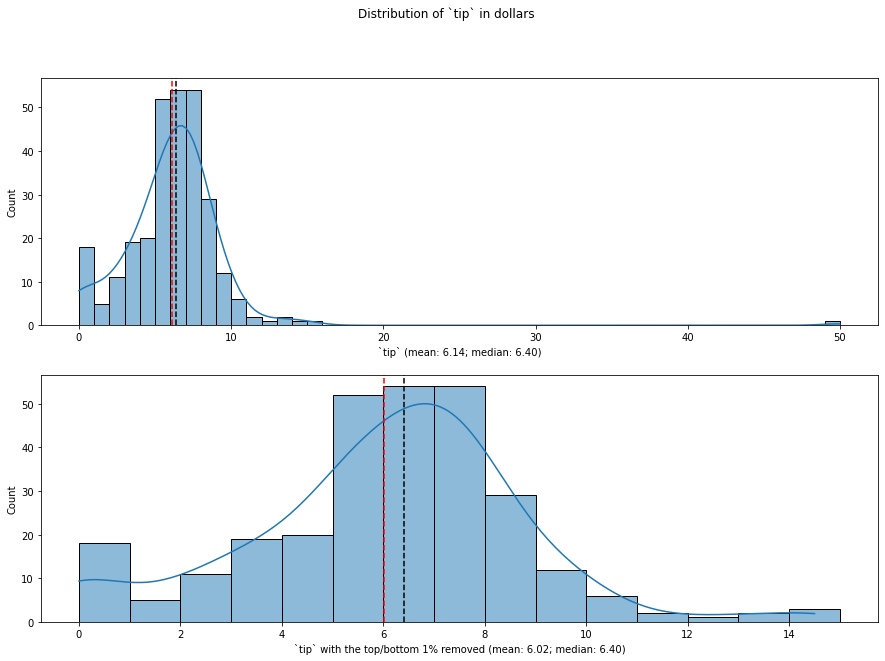

In [51]:
analyze_numeric_var(var = "tip", 
                    df = df.loc[(df["payment_type"] == "CRD") & (df["include_laguardia"] == True)], 
                    binwidth = 1,
                    var_unit = "dollar")

We see that passangers are way more generous for the trips to/from JFK and La Guardia. 

## E. Conclusion and test set treatment

After performing all of the above feature engineering steps, we end up with a train dataframe that has the following columns:

**ID-related**
- `vehicle_id`
- `driver_id`


**Location-related**
- `start_long`
- `start_lat`
- `end_long`
- `end_lat`
- `start_gh`
- `end_gh`
- `trip_group_id`
- `trip_group_id_str`
-  `distance`
- `haversine_distance`
- `manhattan_distance`
- `include_JFK`
- `include_laguardia`


**Time-related**
- `start_time`
- `end_time`
- `duration`
- `start_hour`
- `day`
- `day_start_hour`


**Fare-related**
- `rate_code`
- `fare`
- `tip`
- `payment_type`

In [52]:
# rearranging columns
df = df[['vehicle_id', 'driver_id',
         
         'start_long', 'start_lat', 'end_long', 'end_lat', 'start_gh', 'end_gh', 'trip_group_id',
         'trip_group_id_str', 'distance', 'haversine_distance', 'manhattan_distance','include_JFK',
         'include_laguardia',
         
         'start_time', 'end_time', 'duration', 'start_hour', 'day', 'day_start_hour',
        
         'rate_code', 'fare', 'tip', 'payment_type']]

df.head(1).T

4974
vehicle_id          A9DC75D59E0EA27E1ED328E8BE8CD828
driver_id           02790A43EDEAAB9BC0B8829A8F2C5FD0
start_long                                 -74.00264
start_lat                                  40.728855
end_long                                  -73.973969
end_lat                                    40.762356
start_gh                                      dr5rsn
end_gh                                        dr5rus
trip_group_id                       (dr5rsn, dr5rus)
trip_group_id_str                                 ()
distance                                        2.98
haversine_distance                          4.439656
manhattan_distance                          6.141088
include_JFK                                    False
include_laguardia                              False
start_time                 2013-04-18 08:33:00+00:00
end_time                   2013-04-18 08:52:00+00:00
duration                                        1140
start_hour                                         8
day                                         Thursday
day_start_hour                          Thursday - 8
rate_code                                          1
fare                                            14.5
tip                                              0.0
payment_type                                     CSH

We have applied some filtering logic to the training data to get rid of erroneous/irrelevant rows and engineered some new features. 


Let's apply the same steps to the test data:

### Feature engineering

In [53]:
# location-related
test_df["haversine_distance"] = test_df.apply(lambda x: haversine((x.start_lat, x.start_long), (x.end_lat, x.end_long)), axis = 1)
test_df["manhattan_distance"] = test_df.apply(lambda x: manhattan((x.start_lat, x.start_long), (x.end_lat, x.end_long)), axis = 1)
test_df["start_gh"] = test_df.apply(lambda x: gh.encode(x.start_lat, x.start_long, precision = GH_PRECISION), axis = 1)
test_df["end_gh"] = test_df.apply(lambda x: gh.encode(x.end_lat, x.end_long, precision = GH_PRECISION), axis = 1)
test_df["trip_group_id"] = test_df.apply(lambda x: tuple({x.start_gh, x.end_gh}) if x.start_gh != x.end_gh else (x.start_gh, x.end_gh), axis = 1)
test_df["trip_group_id_str"] = test_df.apply(lambda x: str(x["trip_group_id"][1:-1]), axis = 1)
test_df["include_JFK"] = test_df.apply(lambda x: 
                             (haversine((x.start_lat, x.start_long), JFK_COORD) <= max_distance_mile) or 
                             (haversine(JFK_COORD, (x.end_lat, x.end_long)) <= max_distance_mile), axis = 1)

test_df["include_laguardia"] = test_df.apply(lambda x: 
                             (haversine((x.start_lat, x.start_long), LAGUARDIA_COORD) <= max_distance_mile_laguardia) or 
                             (haversine(LAGUARDIA_COORD, (x.end_lat, x.end_long)) <= max_distance_mile_laguardia), axis = 1)


# time-related
test_df["start_hour"] = test_df["start_time"].dt.hour
test_df["day"] = test_df["start_time"].dt.day_name()
test_df["day_start_hour"] = test_df["day"].str.cat(test_df["start_hour"].astype(str), sep = " - ")


### Filtering

In [54]:
# location-related
test_df = test_df.loc[(test_df.start_lat >= NYC_LAT_LIMITS[0]) & (test_df.start_lat <= NYC_LAT_LIMITS[1])]
test_df = test_df.loc[(test_df.end_lat >= NYC_LAT_LIMITS[0]) & (test_df.end_lat <= NYC_LAT_LIMITS[1])]
test_df = test_df.loc[(test_df.start_long >= NYC_LONG_LIMITS[0]) & (test_df.start_long <= NYC_LONG_LIMITS[1])]
test_df = test_df.loc[(test_df.end_long >= NYC_LONG_LIMITS[0]) & (test_df.end_long <= NYC_LONG_LIMITS[1])]
test_df = filter_numeric_var("distance", test_df,  0)
test_df = filter_numeric_var("haversine_distance", test_df,  0)
test_df = filter_numeric_var("manhattan_distance", test_df,  0)

# time-related
test_df = filter_numeric_var("duration", test_df,  0)

# fare-related
test_df = test_df.loc[test_df["payment_type"].isin(["CSH","CRD"])]
test_df = test_df.loc[test_df["rate_code"].isin([1,2])]

Minimum and maximum values of 'distance' for rows to be included (exclusive): 0
Number of erroneous rows (`distance` related): 15
Shape of the dataframe after filtering out erroneous rows (`distance` related): (2888, 25)

Minimum and maximum values of 'haversine_distance' for rows to be included (exclusive): 0
Number of erroneous rows (`haversine_distance` related): 16
Shape of the dataframe after filtering out erroneous rows (`haversine_distance` related): (2872, 25)

Minimum and maximum values of 'manhattan_distance' for rows to be included (exclusive): 0
Number of erroneous rows (`manhattan_distance` related): 0
Shape of the dataframe after filtering out erroneous rows (`manhattan_distance` related): (2872, 25)

Minimum and maximum values of 'duration' for rows to be included (exclusive): 0
Number of erroneous rows (`duration` related): 0
Shape of the dataframe after filtering out erroneous rows (`duration` related): (2872, 25)



In [55]:
df.shape

(25670, 25)

In [56]:
test_df.shape

(2862, 25)

# 2. Trip group analysis

## Section Summary

This section corresponds to the first question:


*In which <font color = "red"><b>trip groups</font> can you use the groups' <font color = "green"><b>mean values as measures of central tendency</font> to <font color = "blue"><b>estimate fare and duration</font>?*

    
Each colored part in the above sentence represents a problem that requires some analysis/definition. 
To answer this question, I will first tackle each part separately and draw a conclusion afterwards. The s
    
- <font color = "red"><b>Trip groups definition</font>
    
This part has been tackled before in section 1, where I defined a trip group as a collection of trips between the same two geohashes. When defining the trip groups, I do not differentiate between starting and ending points; that is, I consider trips from geohash A to geohash B to behave similarly in terms of duration and fare compared to trips going the opposite direction.
    
Further analysis of each trip group is given by part A. 
    

- <font color = "blue"><b>Estimation of fare and duration for each group</font>
    
    
We can think of each trip group as its own **population**; this population is associated with several **parameters** such as the population-level mean of `fare` and `duration` – $\mu_{duration}$ and $\mu_{fare}$. The few instances from each trip group that we have in our dataset serve as **samples** that represent these populations.
    
The question I will tackle in this subsection is therefore as follows: 
    
*For each trip group, do we have enough samples to confidently draw inferences about their corresponding populations?*
    
Part B will investigate this question depth.
     
- <font color = "green"><b>The use of means as measures of central tendency for each group</font>
    
In statistics, we know several measures of central tendency. For continous variables such as `fare` and `duration`, the most important measures of central tendency are mean and median. 
    
Median is considered as the more robust of the two as its value is not swayed by outliers. The mean value, on the other hand, can diverge from the medians in populations that are skewed.
    
As such, in part C, I will investigate the skewness of each trip group and decide whether or not the group has low enough skewness to warrant the use of mean value as measure of central tendency.


## A. Defining and visualizing trip groups

First, let's create another dataframe, `trip_group_df`, that classifies our trips into different trip groups using the `trip_group_id` we created in section 1.

Afterwards, let's append the representative coordinates for each trip group. 

In [57]:
trip_group_df = df.groupby(["trip_group_id"]).size().reset_index().sort_values(by = 0, ascending = False)
trip_group_df.columns = ["trip_group_id", "n_trips"]
trip_group_df.reset_index(inplace = True, drop = True)

In [58]:
# Geohashes to coordinates
trip_group_df["start_coord"] = trip_group_df.apply(lambda x: gh.decode(x.trip_group_id[0]), axis = 1)
trip_group_df["end_coord"] = trip_group_df.apply(lambda x: gh.decode(x.trip_group_id[1]), axis = 1)
trip_group_df.set_index("trip_group_id", inplace = True)

Let's now visualize the 5 most common trips in our dataset.

In [87]:
fig=Figure(width=1000,height=600)

m = folium.Map(
    location=[(NYC_LAT_LIMITS[0] + NYC_LAT_LIMITS[1])/2, (NYC_LONG_LIMITS[0] + NYC_LONG_LIMITS[1])/2],
    zoom_start=12,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=True,
    tiles = "CartoDB positron",
)

#add lines
TOP_N = 5
no = 1
for idx, row in trip_group_df.head(TOP_N).iterrows():
    start_addr = coord_to_addr(row["start_coord"])
    end_addr = coord_to_addr(row["end_coord"])
    points = [row["start_coord"], row["end_coord"]]
    folium.PolyLine(points, 
                    weight=5, 
                    opacity=1, 
                    tooltip = str(no) + ") " + start_addr + " -- " + end_addr).add_to(m)
    
    no = no + 1


print("Most common trip groups in NYC:")
fig.add_child(m)

Most common trip groups in NYC:


We see that the most common trips in our dataset take place in central Manhattan near Broadway.

It does make sense that theatre-goers, most of whom are relatively wealthy and want to arrive to their shows on time by taking cabs (hence avoiding NYC's infamous public transport system).


## B. Calculating minimum sample size for population mean estimation

### Background theory

Having defined the trip group, now I'm interested to see if I can use the samples within the group to 

As mentioned before, we can think of each trip group as its own **population**; this population is associated with several **parameters** such as the population-level mean of `fare` and `duration` – $\mu_{duration}$ and $\mu_{fare}$. If, hypothetically, we had access to every single trip within each trip group, we would be able to calculate these parameters. 

Unfortunately, we don't have such an exhaustive dataset. What we do have is **limited number** of trips for each trip group in the dataset, which we can regard as **samples**. From this, we can easily calculate some **statistics**, such as sample-level averages of `duration` and `fare` – $\bar{X}_{duration}$ and $\bar{X}_{fare}$.

The question now is:

*For each trip group - do we have sufficient sample size to confidently extrapolate the population-level means $\mu_{duration}$ and $\mu_{fare}$  from the sample-level means $\bar{X}_{duration}$ and $\bar{X}_{fare}$?*

To answer this, we need to review some statistical concepts surrounding parameter estimation.

We know that estimates are never perfect. When we use a sample statistic (e.g. the sample mean) to estimate a parameter (e.g. the population mean), our estimate will be associated with a certain *confidence interval (CI)*.
CI is a range of estimates, defined by a lower bound and upper bound, for an unknown parameter. This interval is computed at a designated confidence level. 

The width of this interval depends on three things:
- the sample size
- the confidence level
- and the amount of variance within the data (as represented by the standard deviation).

To be more precise, the confidence interval for population mean is governed by the following equation:


$$
CI = \bar{x} \pm z \frac{\sigma}{\sqrt{n}}
$$



where:
- $\bar{x}$ is the sample mean
- z is a standard Z-score for the desired level of confidence (1.96 for a 95% confidence interval)
- $\sigma$ is the sample standard deviation. If $\sigma$ is unknown, like in our case, we can substitute it with the worst-case scenario.
- $n$ is the number of samples we have.

If we define the margin of error, MoE, to be half of the width of this interval, we can rearrange the equation to obtain the formula for $n$, the minimum number of samples to obtain a desired level of confidence given a certain population standard deviation and a certain margin of error:



$$
n \geq {(\frac{z * \sigma}{MoE})}^2
$$

 


In [60]:
# for duration:

z_duration = 1.96
sigma_duration = np.std(df["duration"])
MoE_duration = 180
# MoE has the same unit as the variable being analyzed. 
# for `duration`, the MoE has a unit of seconds
# A margin of error of 180 seconds (3 minutes) when estimating duration of a trip seem reasonable.

# this is to "round up" the float
n_duration = int((z_duration*sigma_duration/MoE_duration)**2 + 1)
n_duration

34

Note that the value for the $\sigma$ I used above comes from the standard deviation of the `duration` variable in the dataset. The standard deviation is technically not the same as the population standard deviation of the `duration` variable for each trip group, but we will use this number as a proxy.

In [61]:
# for fare:

z_fare = 1.96
sigma_fare = np.std(df["fare"])
MoE_fare = 2
# Again, MoE has the same unit as the variable being analyzed. 
# for `fare`, the MoE has a unit of dollars
# A margin of error of USD 2 when estimating fare seem reasonable

n_fare = (z_fare*sigma_fare/MoE_fare)**2
n_fare

110.58215342069467

We will use the larger one between the above two to determine whether a trip group is large enough for both `fare` and `duration` inferences to be made from it.

In [62]:
trip_group_df["enough_sample_size"] = False
N_TRIPS_THRESHOLD = max(n_fare, n_duration)
trip_group_df["enough_sample_size"] = trip_group_df["n_trips"] >= N_TRIPS_THRESHOLD
percentage = trip_group_df["enough_sample_size"].sum()/len(trip_group_df)*100
print(f"{percentage:.2f}% of the trip groups have enough sample size (n_trips > {N_TRIPS_THRESHOLD})" )
print("These trip groups's sample means can be used to approximate the population means." )


0.04% of the trip groups have enough sample size (n_trips > 110.58215342069467)
These trip groups's sample means can be used to approximate the population means.


## C. Using sample means to estimate the value of a random variable

### Background theory



The mean is usually the best measure of central tendency to use when our data distribution is continuous and symmetrical, for example, when the data is normally distributed. If the data is skewed, then the median is usually preferred.

As such, we are going to measure the skewness of the in-group distribution of `fare`. and `duration` for each trip group.

This will be done using the [`skewtest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html) function from scipy, which tests whether the skew is different from the normal distribution. This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

A p value below the treshold of 0.05 indicates absence of skewness.

### Measuring the skewness of `fare` and `duration`  within each trip group

In [63]:
trip_group_df["fare_skewness_pval"] = None
trip_group_df["duration_skewness_pval"] = None
trip_group_df["fare_is_not_skewed"] = None
trip_group_df["duration_is_not_skewed"] = None

In [64]:
PVAL_THRESH = 0.05
for trip_group_id, row in trip_group_df[trip_group_df["enough_sample_size"] == True].iterrows():
    _df = df.loc[df["trip_group_id"] == trip_group_id]
    fare_skewness_pval = skewtest(_df["fare"])[1]
    duration_skewness_pval = skewtest(_df["duration"])[1]
    
    trip_group_df.at[trip_group_id, "fare_skewness_pval"] = fare_skewness_pval
    trip_group_df.at[trip_group_id, "duration_skewness_pval"] = duration_skewness_pval
    trip_group_df.at[trip_group_id, "fare_is_not_skewed"] = fare_skewness_pval <= PVAL_THRESH
    trip_group_df.at[trip_group_id, "duration_is_not_skewed"] = duration_skewness_pval <= PVAL_THRESH

In [65]:
percentage_fare = trip_group_df["fare_is_not_skewed"].sum()/len(trip_group_df)*100
print(f"{percentage_fare:.2f}% of the trip groups have a fare distribution that is not skewed, for which mean can be used as a measure of central tendency")

percentage_duration = trip_group_df["duration_is_not_skewed"].sum()/len(trip_group_df)*100
print(f"{percentage_fare:.2f}% of the trip groups have a duration distribution that is not skewed, for which mean can be used as a measure of central tendency")


0.02% of the trip groups have a fare distribution that is not skewed, for which mean can be used as a measure of central tendency
0.02% of the trip groups have a duration distribution that is not skewed, for which mean can be used as a measure of central tendency


## D. Conclusion

There are very few trip groups for which:
- we have enough samples to make inferences about `duration` and `fare` population means
- the distribution of  `duration` and `fare` in these groups are not skewed, hence their mean values can be used as a measure of central tendency

# 3. Modeling

## Section summary

This section focuses on the training and evaluation of two machine learning models: fare prediction model and tip prediction model.

The steps to building the fare and tip prediction model is as follows:

**1. Train test split**

This was the first thing we did in section 1, where I split our dataset into train and test sets with a ratio of 9:1.

**2. EDA and feature engineering**

These steps were done in section 1, where I explored the train set and engineer features I expected to have some predictive powers in the modeling steps.

**3. Modeling**

For both tip and fare prediction, three regression models are created using the train set. The models are evaluated using RMSE against the test set; both in its entirety as well as portion-wise to detect bias. 

- **1. Hardcoded-model**


- **2. All-features model**


- **3. Selected-features model**





## A. Modeling: `fare`

### model 1: hardcoded rule

There exists an “official” way of calculating the total fare, which uses a formula that takes into account, among other, the distance travelled, the time of travel, and the locations.

I am going to simply this official formula and use this fare-calculation formula as my first “model”. This model will serve as my baseline.

Below is the rule, taken from NYC taxi [website](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)

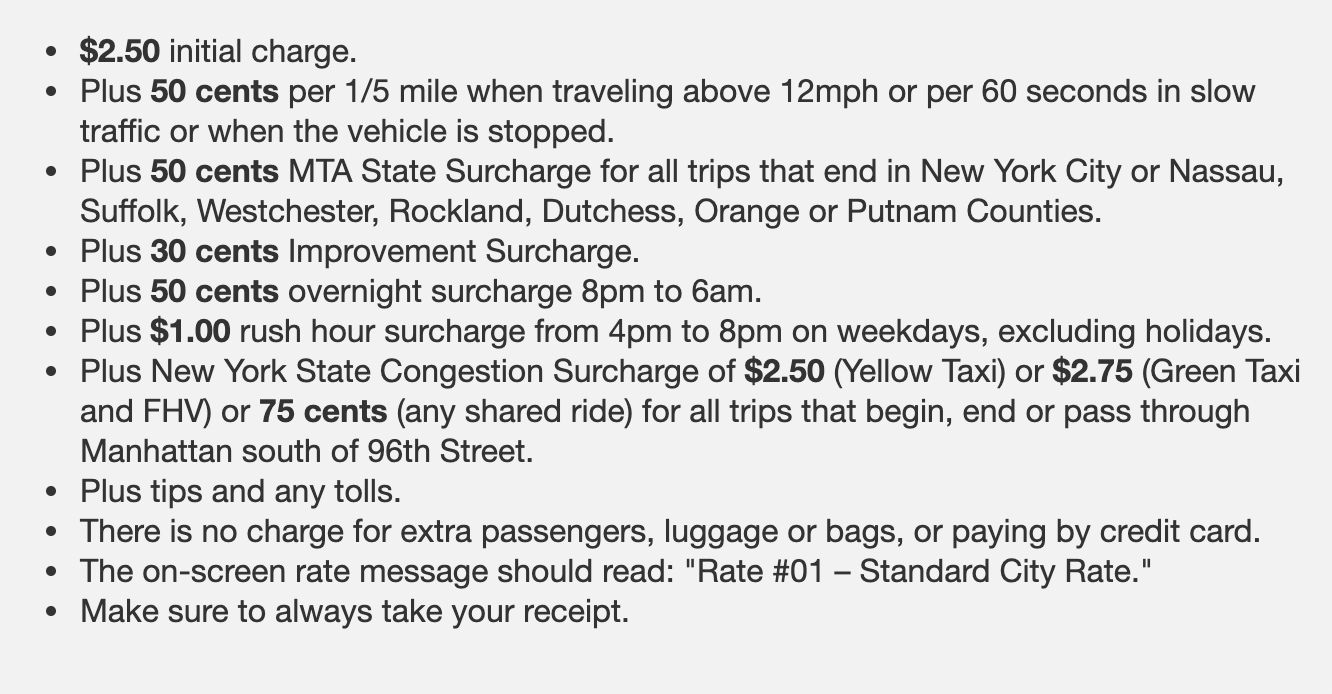

We will simplify this as follows:


fare = 5 + `haversine_distance`*2.5  

Where 5 refers to a simplified lumpsump that includes initial charge and surcharges and 2.5 refers to the fare of 50 cents per 1/5 mile.

In [66]:
TARGET = "fare"
y_test = test_df[TARGET]
y_test_pred = 5 + test_df["haversine_distance"]*2.5

The error for this model for the entire test set is as follows:

In [67]:
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 4.48
Mean error (prediction - true value): USD -1.07


Now let's take a look at the RMSE for (test set) trips to or from the airport:

In [68]:
_df = test_df.loc[test_df["include_JFK"] == True]
y_test = _df[TARGET]
y_test_pred = 5 + _df["haversine_distance"]*2.5

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 11.58
Mean error (prediction - true value): USD -5.18


In [69]:
_df = test_df.loc[test_df["include_laguardia"] == True]
y_test = _df[TARGET]
y_test_pred = 5 + _df["haversine_distance"]*2.5

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 11.98
Mean error (prediction - true value): USD -8.81


We see that our simple hard coded model constantly underestimates total fare.

This is even more severe in airport trips, which (1) as we have seen, usually are associated with higher tips and (2) might involve more tolls and surcharges.

### Model 2: All features

Here, we will train a CatBoostRegressor model using all the features we engineered from the drop-off/pick-up points and the time of travel.

In [70]:
ALL_FEATURES = ["start_long",
                "start_lat",
                "end_long", 
                "end_lat",  
                "start_gh", 
                "end_gh", 
                "trip_group_id_str", 
                "include_JFK",
                "include_laguardia",
                "haversine_distance",
                "manhattan_distance", 
                "start_hour",
                "day",
                "day_start_hour",
               ]

TARGET = "fare"

In [71]:
X_train = df[ALL_FEATURES]
y_train = df[TARGET]

In [72]:
cat_features_indices = np.where(X_train.dtypes != np.float)[0]
reg =  CatBoostRegressor()
reg.fit(X_train,y_train, cat_features=cat_features_indices)

Learning rate set to 0.068371
0:	learn: 10.1454924	total: 75.8ms	remaining: 1m 15s
1:	learn: 9.6069348	total: 96.4ms	remaining: 48.1s
2:	learn: 9.1156698	total: 113ms	remaining: 37.6s
3:	learn: 8.6593903	total: 133ms	remaining: 33.1s
4:	learn: 8.2457890	total: 148ms	remaining: 29.5s
5:	learn: 7.8586054	total: 165ms	remaining: 27.3s
6:	learn: 7.5100487	total: 182ms	remaining: 25.9s
7:	learn: 7.1861062	total: 201ms	remaining: 24.9s
8:	learn: 6.8920417	total: 217ms	remaining: 23.9s
9:	learn: 6.6263625	total: 232ms	remaining: 23s
10:	learn: 6.3792132	total: 248ms	remaining: 22.3s
11:	learn: 6.1545087	total: 266ms	remaining: 21.9s
12:	learn: 5.9412655	total: 284ms	remaining: 21.5s
13:	learn: 5.7510657	total: 303ms	remaining: 21.4s
14:	learn: 5.5813662	total: 322ms	remaining: 21.1s
15:	learn: 5.4234134	total: 339ms	remaining: 20.8s
16:	learn: 5.2826236	total: 356ms	remaining: 20.6s
17:	learn: 5.1501731	total: 372ms	remaining: 20.3s
18:	learn: 5.0355714	total: 390ms	remaining: 20.1s
19:	learn

161:	learn: 3.6895626	total: 2.53s	remaining: 13.1s
162:	learn: 3.6895526	total: 2.54s	remaining: 13s
163:	learn: 3.6885322	total: 2.56s	remaining: 13s
164:	learn: 3.6881003	total: 2.57s	remaining: 13s
165:	learn: 3.6867889	total: 2.58s	remaining: 13s
166:	learn: 3.6846023	total: 2.6s	remaining: 13s
167:	learn: 3.6828632	total: 2.62s	remaining: 13s
168:	learn: 3.6792469	total: 2.63s	remaining: 12.9s
169:	learn: 3.6754317	total: 2.65s	remaining: 12.9s
170:	learn: 3.6745346	total: 2.66s	remaining: 12.9s
171:	learn: 3.6733436	total: 2.68s	remaining: 12.9s
172:	learn: 3.6717517	total: 2.69s	remaining: 12.9s
173:	learn: 3.6709651	total: 2.7s	remaining: 12.8s
174:	learn: 3.6674262	total: 2.72s	remaining: 12.8s
175:	learn: 3.6658518	total: 2.74s	remaining: 12.8s
176:	learn: 3.6646643	total: 2.75s	remaining: 12.8s
177:	learn: 3.6646331	total: 2.76s	remaining: 12.8s
178:	learn: 3.6625663	total: 2.78s	remaining: 12.7s
179:	learn: 3.6608960	total: 2.79s	remaining: 12.7s
180:	learn: 3.6580894	tota

328:	learn: 3.4859321	total: 5.16s	remaining: 10.5s
329:	learn: 3.4839436	total: 5.18s	remaining: 10.5s
330:	learn: 3.4823646	total: 5.19s	remaining: 10.5s
331:	learn: 3.4819764	total: 5.21s	remaining: 10.5s
332:	learn: 3.4816151	total: 5.23s	remaining: 10.5s
333:	learn: 3.4807893	total: 5.25s	remaining: 10.5s
334:	learn: 3.4799677	total: 5.26s	remaining: 10.5s
335:	learn: 3.4798122	total: 5.28s	remaining: 10.4s
336:	learn: 3.4792743	total: 5.29s	remaining: 10.4s
337:	learn: 3.4785883	total: 5.3s	remaining: 10.4s
338:	learn: 3.4783020	total: 5.32s	remaining: 10.4s
339:	learn: 3.4777853	total: 5.33s	remaining: 10.3s
340:	learn: 3.4760404	total: 5.34s	remaining: 10.3s
341:	learn: 3.4737952	total: 5.36s	remaining: 10.3s
342:	learn: 3.4730205	total: 5.38s	remaining: 10.3s
343:	learn: 3.4719178	total: 5.4s	remaining: 10.3s
344:	learn: 3.4712809	total: 5.42s	remaining: 10.3s
345:	learn: 3.4698702	total: 5.43s	remaining: 10.3s
346:	learn: 3.4686131	total: 5.45s	remaining: 10.3s
347:	learn: 3.

489:	learn: 3.3580033	total: 7.68s	remaining: 7.99s
490:	learn: 3.3570082	total: 7.7s	remaining: 7.98s
491:	learn: 3.3563631	total: 7.71s	remaining: 7.96s
492:	learn: 3.3561130	total: 7.73s	remaining: 7.95s
493:	learn: 3.3547262	total: 7.75s	remaining: 7.94s
494:	learn: 3.3542718	total: 7.76s	remaining: 7.92s
495:	learn: 3.3539627	total: 7.77s	remaining: 7.9s
496:	learn: 3.3535865	total: 7.79s	remaining: 7.88s
497:	learn: 3.3528769	total: 7.8s	remaining: 7.87s
498:	learn: 3.3519277	total: 7.82s	remaining: 7.85s
499:	learn: 3.3508835	total: 7.84s	remaining: 7.84s
500:	learn: 3.3488346	total: 7.85s	remaining: 7.82s
501:	learn: 3.3481914	total: 7.87s	remaining: 7.81s
502:	learn: 3.3464654	total: 7.89s	remaining: 7.79s
503:	learn: 3.3459871	total: 7.9s	remaining: 7.78s
504:	learn: 3.3453932	total: 7.92s	remaining: 7.76s
505:	learn: 3.3450323	total: 7.93s	remaining: 7.74s
506:	learn: 3.3446527	total: 7.95s	remaining: 7.73s
507:	learn: 3.3439723	total: 7.97s	remaining: 7.72s
508:	learn: 3.34

654:	learn: 3.2470334	total: 10.3s	remaining: 5.42s
655:	learn: 3.2467130	total: 10.3s	remaining: 5.41s
656:	learn: 3.2458294	total: 10.3s	remaining: 5.39s
657:	learn: 3.2449864	total: 10.4s	remaining: 5.38s
658:	learn: 3.2446922	total: 10.4s	remaining: 5.36s
659:	learn: 3.2443179	total: 10.4s	remaining: 5.35s
660:	learn: 3.2427676	total: 10.4s	remaining: 5.33s
661:	learn: 3.2421944	total: 10.4s	remaining: 5.32s
662:	learn: 3.2415716	total: 10.4s	remaining: 5.3s
663:	learn: 3.2408334	total: 10.4s	remaining: 5.29s
664:	learn: 3.2404971	total: 10.5s	remaining: 5.27s
665:	learn: 3.2398088	total: 10.5s	remaining: 5.25s
666:	learn: 3.2393457	total: 10.5s	remaining: 5.24s
667:	learn: 3.2391205	total: 10.5s	remaining: 5.22s
668:	learn: 3.2390266	total: 10.5s	remaining: 5.21s
669:	learn: 3.2385419	total: 10.5s	remaining: 5.19s
670:	learn: 3.2371642	total: 10.6s	remaining: 5.18s
671:	learn: 3.2368168	total: 10.6s	remaining: 5.16s
672:	learn: 3.2358577	total: 10.6s	remaining: 5.15s
673:	learn: 3

820:	learn: 3.1532115	total: 13s	remaining: 2.83s
821:	learn: 3.1530277	total: 13s	remaining: 2.82s
822:	learn: 3.1521644	total: 13s	remaining: 2.8s
823:	learn: 3.1514507	total: 13s	remaining: 2.79s
824:	learn: 3.1509506	total: 13.1s	remaining: 2.77s
825:	learn: 3.1508991	total: 13.1s	remaining: 2.75s
826:	learn: 3.1506810	total: 13.1s	remaining: 2.74s
827:	learn: 3.1500144	total: 13.1s	remaining: 2.72s
828:	learn: 3.1497394	total: 13.1s	remaining: 2.71s
829:	learn: 3.1491554	total: 13.1s	remaining: 2.69s
830:	learn: 3.1482973	total: 13.2s	remaining: 2.67s
831:	learn: 3.1475553	total: 13.2s	remaining: 2.66s
832:	learn: 3.1471955	total: 13.2s	remaining: 2.64s
833:	learn: 3.1470084	total: 13.2s	remaining: 2.63s
834:	learn: 3.1451538	total: 13.2s	remaining: 2.61s
835:	learn: 3.1447197	total: 13.2s	remaining: 2.6s
836:	learn: 3.1443501	total: 13.3s	remaining: 2.58s
837:	learn: 3.1442928	total: 13.3s	remaining: 2.56s
838:	learn: 3.1436642	total: 13.3s	remaining: 2.55s
839:	learn: 3.1426569	

987:	learn: 3.0774798	total: 15.7s	remaining: 191ms
988:	learn: 3.0772563	total: 15.7s	remaining: 175ms
989:	learn: 3.0771143	total: 15.7s	remaining: 159ms
990:	learn: 3.0768316	total: 15.8s	remaining: 143ms
991:	learn: 3.0764374	total: 15.8s	remaining: 127ms
992:	learn: 3.0763447	total: 15.8s	remaining: 111ms
993:	learn: 3.0757545	total: 15.8s	remaining: 95.4ms
994:	learn: 3.0756155	total: 15.8s	remaining: 79.5ms
995:	learn: 3.0752229	total: 15.8s	remaining: 63.6ms
996:	learn: 3.0751142	total: 15.8s	remaining: 47.7ms
997:	learn: 3.0750105	total: 15.9s	remaining: 31.8ms
998:	learn: 3.0746741	total: 15.9s	remaining: 15.9ms
999:	learn: 3.0742584	total: 15.9s	remaining: 0us


In [73]:
y_test = test_df[TARGET]
X_test = test_df[ALL_FEATURES]
y_test_pred = reg.predict(X_test)
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 3.66
Mean error (prediction - true value): USD -0.00


In [74]:
_df = test_df.loc[test_df["include_JFK"] == True]
y_test = _df[TARGET]
X_test = _df[ALL_FEATURES]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 10.63
Mean error (prediction - true value): USD -0.01


In [75]:
_df = test_df.loc[test_df["include_laguardia"] == True]
y_test = _df[TARGET]
X_test = _df[ALL_FEATURES]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 5.27
Mean error (prediction - true value): USD -0.67


Now let's investigate the feature importance:

In [76]:
feature_importance_df = pd.concat([pd.Series(reg.feature_names_),pd.Series(reg.feature_importances_)], axis = 1)
feature_importance_df.columns = ["feature", "importance"]
feature_importance_df.sort_values(by = "importance", inplace = True, ascending = False)
feature_importance_df

feature  importance
9   haversine_distance   42.851076
10  manhattan_distance   17.973191
7          include_JFK    6.008317
0           start_long    5.921264
2             end_long    5.279614
3              end_lat    5.114962
5               end_gh    4.149747
4             start_gh    3.511375
1            start_lat    2.912353
11          start_hour    2.612709
13      day_start_hour    1.822108
8    include_laguardia    0.951857
12                 day    0.891427
6    trip_group_id_str    0.000000

As expected, the distance metrics exhibit higher feature importance.

### model 3: selected features

In [77]:
top_features = feature_importance_df.head(5)["feature"].values

In [78]:
X_train = df[top_features]
y_train = df[TARGET]

In [79]:
cat_features_indices = np.where(X_train.dtypes != np.float)[0]
reg =  CatBoostRegressor()
reg.fit(X_train,y_train, cat_features=cat_features_indices)

Learning rate set to 0.068371
0:	learn: 10.1398298	total: 3.14ms	remaining: 3.14s
1:	learn: 9.6008386	total: 6.22ms	remaining: 3.1s
2:	learn: 9.1066351	total: 9.24ms	remaining: 3.07s
3:	learn: 8.6551435	total: 12.5ms	remaining: 3.11s
4:	learn: 8.2345571	total: 15.5ms	remaining: 3.08s
5:	learn: 7.8506867	total: 18.5ms	remaining: 3.06s
6:	learn: 7.5050403	total: 21.4ms	remaining: 3.04s
7:	learn: 7.1754710	total: 24.4ms	remaining: 3.03s
8:	learn: 6.8761927	total: 27.5ms	remaining: 3.03s
9:	learn: 6.5978083	total: 30.5ms	remaining: 3.02s
10:	learn: 6.3512319	total: 33.5ms	remaining: 3.01s
11:	learn: 6.1178369	total: 36.3ms	remaining: 2.99s
12:	learn: 5.9050897	total: 39.2ms	remaining: 2.98s
13:	learn: 5.7132193	total: 42ms	remaining: 2.96s
14:	learn: 5.5435622	total: 45ms	remaining: 2.95s
15:	learn: 5.3923078	total: 47.8ms	remaining: 2.94s
16:	learn: 5.2539659	total: 51.9ms	remaining: 3s
17:	learn: 5.1326542	total: 54.7ms	remaining: 2.98s
18:	learn: 5.0144661	total: 57.5ms	remaining: 2.97s

187:	learn: 3.8380245	total: 572ms	remaining: 2.47s
188:	learn: 3.8365105	total: 576ms	remaining: 2.47s
189:	learn: 3.8357974	total: 578ms	remaining: 2.47s
190:	learn: 3.8342234	total: 582ms	remaining: 2.46s
191:	learn: 3.8332545	total: 585ms	remaining: 2.46s
192:	learn: 3.8317337	total: 588ms	remaining: 2.46s
193:	learn: 3.8307789	total: 591ms	remaining: 2.46s
194:	learn: 3.8297833	total: 595ms	remaining: 2.46s
195:	learn: 3.8288693	total: 598ms	remaining: 2.45s
196:	learn: 3.8283983	total: 601ms	remaining: 2.45s
197:	learn: 3.8280732	total: 604ms	remaining: 2.44s
198:	learn: 3.8263735	total: 606ms	remaining: 2.44s
199:	learn: 3.8244815	total: 609ms	remaining: 2.44s
200:	learn: 3.8238477	total: 612ms	remaining: 2.43s
201:	learn: 3.8225100	total: 615ms	remaining: 2.43s
202:	learn: 3.8213271	total: 618ms	remaining: 2.43s
203:	learn: 3.8202186	total: 621ms	remaining: 2.42s
204:	learn: 3.8182574	total: 626ms	remaining: 2.43s
205:	learn: 3.8171579	total: 629ms	remaining: 2.42s
206:	learn: 

374:	learn: 3.6854127	total: 1.14s	remaining: 1.9s
375:	learn: 3.6848228	total: 1.15s	remaining: 1.9s
376:	learn: 3.6840505	total: 1.15s	remaining: 1.9s
377:	learn: 3.6834407	total: 1.15s	remaining: 1.89s
378:	learn: 3.6825747	total: 1.15s	remaining: 1.89s
379:	learn: 3.6818474	total: 1.16s	remaining: 1.89s
380:	learn: 3.6813534	total: 1.16s	remaining: 1.89s
381:	learn: 3.6810162	total: 1.16s	remaining: 1.88s
382:	learn: 3.6800572	total: 1.17s	remaining: 1.88s
383:	learn: 3.6796218	total: 1.17s	remaining: 1.88s
384:	learn: 3.6790755	total: 1.17s	remaining: 1.87s
385:	learn: 3.6783018	total: 1.17s	remaining: 1.87s
386:	learn: 3.6779754	total: 1.18s	remaining: 1.86s
387:	learn: 3.6774388	total: 1.18s	remaining: 1.86s
388:	learn: 3.6768056	total: 1.18s	remaining: 1.86s
389:	learn: 3.6762874	total: 1.19s	remaining: 1.85s
390:	learn: 3.6752408	total: 1.19s	remaining: 1.85s
391:	learn: 3.6747093	total: 1.19s	remaining: 1.85s
392:	learn: 3.6740711	total: 1.2s	remaining: 1.85s
393:	learn: 3.67

565:	learn: 3.5797155	total: 1.72s	remaining: 1.32s
566:	learn: 3.5795481	total: 1.72s	remaining: 1.31s
567:	learn: 3.5788591	total: 1.72s	remaining: 1.31s
568:	learn: 3.5781975	total: 1.73s	remaining: 1.31s
569:	learn: 3.5779514	total: 1.73s	remaining: 1.3s
570:	learn: 3.5775798	total: 1.73s	remaining: 1.3s
571:	learn: 3.5770187	total: 1.74s	remaining: 1.3s
572:	learn: 3.5767205	total: 1.74s	remaining: 1.29s
573:	learn: 3.5760924	total: 1.74s	remaining: 1.29s
574:	learn: 3.5759514	total: 1.74s	remaining: 1.29s
575:	learn: 3.5755056	total: 1.75s	remaining: 1.28s
576:	learn: 3.5750127	total: 1.75s	remaining: 1.28s
577:	learn: 3.5741895	total: 1.75s	remaining: 1.28s
578:	learn: 3.5735953	total: 1.75s	remaining: 1.28s
579:	learn: 3.5729253	total: 1.76s	remaining: 1.27s
580:	learn: 3.5724345	total: 1.76s	remaining: 1.27s
581:	learn: 3.5717298	total: 1.76s	remaining: 1.27s
582:	learn: 3.5710564	total: 1.77s	remaining: 1.26s
583:	learn: 3.5703170	total: 1.77s	remaining: 1.26s
584:	learn: 3.5

757:	learn: 3.4901393	total: 2.3s	remaining: 734ms
758:	learn: 3.4897885	total: 2.3s	remaining: 730ms
759:	learn: 3.4892279	total: 2.3s	remaining: 727ms
760:	learn: 3.4883460	total: 2.31s	remaining: 725ms
761:	learn: 3.4877310	total: 2.31s	remaining: 721ms
762:	learn: 3.4874285	total: 2.31s	remaining: 719ms
763:	learn: 3.4868568	total: 2.32s	remaining: 715ms
764:	learn: 3.4863071	total: 2.32s	remaining: 712ms
765:	learn: 3.4857014	total: 2.32s	remaining: 709ms
766:	learn: 3.4851968	total: 2.32s	remaining: 706ms
767:	learn: 3.4848128	total: 2.33s	remaining: 703ms
768:	learn: 3.4841279	total: 2.33s	remaining: 700ms
769:	learn: 3.4836919	total: 2.33s	remaining: 697ms
770:	learn: 3.4832625	total: 2.33s	remaining: 694ms
771:	learn: 3.4827182	total: 2.34s	remaining: 691ms
772:	learn: 3.4821399	total: 2.34s	remaining: 688ms
773:	learn: 3.4817183	total: 2.34s	remaining: 685ms
774:	learn: 3.4815336	total: 2.35s	remaining: 681ms
775:	learn: 3.4812092	total: 2.35s	remaining: 679ms
776:	learn: 3.4

945:	learn: 3.4130739	total: 2.87s	remaining: 164ms
946:	learn: 3.4127114	total: 2.88s	remaining: 161ms
947:	learn: 3.4123296	total: 2.88s	remaining: 158ms
948:	learn: 3.4121582	total: 2.88s	remaining: 155ms
949:	learn: 3.4117109	total: 2.88s	remaining: 152ms
950:	learn: 3.4112369	total: 2.89s	remaining: 149ms
951:	learn: 3.4110489	total: 2.89s	remaining: 146ms
952:	learn: 3.4108497	total: 2.89s	remaining: 143ms
953:	learn: 3.4103784	total: 2.9s	remaining: 140ms
954:	learn: 3.4099656	total: 2.9s	remaining: 137ms
955:	learn: 3.4090765	total: 2.9s	remaining: 134ms
956:	learn: 3.4087783	total: 2.9s	remaining: 131ms
957:	learn: 3.4085422	total: 2.91s	remaining: 127ms
958:	learn: 3.4084146	total: 2.91s	remaining: 124ms
959:	learn: 3.4081442	total: 2.91s	remaining: 121ms
960:	learn: 3.4076269	total: 2.92s	remaining: 118ms
961:	learn: 3.4072875	total: 2.92s	remaining: 115ms
962:	learn: 3.4068152	total: 2.92s	remaining: 112ms
963:	learn: 3.4065256	total: 2.93s	remaining: 109ms
964:	learn: 3.40

In [80]:
y_test = test_df[TARGET]
X_test = test_df[top_features]
y_test_pred = reg.predict(X_test)
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 3.92
Mean error (prediction - true value): USD 0.02


In [81]:
_df = test_df.loc[test_df["include_JFK"] == True]
y_test = _df[TARGET]
X_test = _df[top_features]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 11.04
Mean error (prediction - true value): USD -0.31


In [82]:
_df = test_df.loc[test_df["include_laguardia"] == True]
y_test = _df[TARGET]
X_test = _df[top_features]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 6.10
Mean error (prediction - true value): USD -0.24


## B. Modeling: `tip`

In [91]:
# We'll only use trips paid using credit card
df2 = df[df["payment_type"] == "CRD"]
test_df2 = test_df[test_df["payment_type"] == "CRD"]

### model 1: hardcoded rule

We will simplify this as follows:

fare = 5 + `haversine_distance`*2.5  
tip = 10% * fare

Where 5 refers to a simplified lumpsump that includes initial charge and surcharges and 2.5 refers to the fare of 50 

In [93]:
TARGET = "tip"
y_test = test_df2[TARGET]
y_test_pred = (5 + test_df2["haversine_distance"]*2.5)*0.1

The error for this model for the entire test set is as follows:

In [94]:
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 1.84
Mean error (prediction - true value): USD -1.03


Now let's take a look at the RMSE for (test set) trips to or from the airport:

In [95]:
_df2 = test_df2.loc[test_df2["include_JFK"] == True]
y_test = _df2[TARGET]
y_test_pred = (5 + _df2["haversine_distance"]*2.5)*0.1

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 5.20
Mean error (prediction - true value): USD -3.80


In [96]:
_df2 = test_df2.loc[test_df2["include_laguardia"] == True]
y_test = _df2[TARGET]
y_test_pred = (5 + _df2["haversine_distance"]*2.5)*0.1

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 4.28
Mean error (prediction - true value): USD -3.71


We see that our simple hard coded model constantly underestimates tip. 

### Model 2: All features

Here, we will train a CatBoostRegressor model using all the features we engineered from the drop-off/pick-up points and the time of travel.

In [99]:
ALL_FEATURES = ["start_long",
                "start_lat",
                "end_long", 
                "end_lat",  
                "start_gh", 
                "end_gh", 
                "trip_group_id_str", 
                "include_JFK",
                "include_laguardia",
                "haversine_distance",
                "manhattan_distance", 
                "start_hour",
                "day",
                "day_start_hour",
               ]

TARGET = "tip"

In [100]:
X_train = df2[ALL_FEATURES]
y_train = df2[TARGET]

In [101]:
cat_features_indices = np.where(X_train.dtypes != np.float)[0]
reg =  CatBoostRegressor()
reg.fit(X_train,y_train, cat_features=cat_features_indices)

Learning rate set to 0.062032
0:	learn: 2.1809449	total: 25.5ms	remaining: 25.5s
1:	learn: 2.1199797	total: 41ms	remaining: 20.5s
2:	learn: 2.0641070	total: 55.5ms	remaining: 18.5s
3:	learn: 2.0119503	total: 70.3ms	remaining: 17.5s
4:	learn: 1.9647209	total: 84.2ms	remaining: 16.8s
5:	learn: 1.9225998	total: 97.3ms	remaining: 16.1s
6:	learn: 1.8844517	total: 109ms	remaining: 15.5s
7:	learn: 1.8525032	total: 116ms	remaining: 14.4s
8:	learn: 1.8205873	total: 129ms	remaining: 14.2s
9:	learn: 1.7921742	total: 139ms	remaining: 13.8s
10:	learn: 1.7659140	total: 151ms	remaining: 13.5s
11:	learn: 1.7419902	total: 161ms	remaining: 13.3s
12:	learn: 1.7211465	total: 173ms	remaining: 13.2s
13:	learn: 1.7031877	total: 180ms	remaining: 12.7s
14:	learn: 1.6859583	total: 193ms	remaining: 12.7s
15:	learn: 1.6702417	total: 205ms	remaining: 12.6s
16:	learn: 1.6577418	total: 210ms	remaining: 12.2s
17:	learn: 1.6455535	total: 224ms	remaining: 12.2s
18:	learn: 1.6337666	total: 236ms	remaining: 12.2s
19:	lea

163:	learn: 1.4272290	total: 1.61s	remaining: 8.2s
164:	learn: 1.4271471	total: 1.62s	remaining: 8.2s
165:	learn: 1.4265500	total: 1.63s	remaining: 8.19s
166:	learn: 1.4264506	total: 1.64s	remaining: 8.19s
167:	learn: 1.4264426	total: 1.65s	remaining: 8.18s
168:	learn: 1.4256141	total: 1.66s	remaining: 8.17s
169:	learn: 1.4255592	total: 1.67s	remaining: 8.15s
170:	learn: 1.4249129	total: 1.68s	remaining: 8.15s
171:	learn: 1.4230883	total: 1.69s	remaining: 8.14s
172:	learn: 1.4230881	total: 1.7s	remaining: 8.12s
173:	learn: 1.4230492	total: 1.7s	remaining: 8.09s
174:	learn: 1.4224431	total: 1.71s	remaining: 8.08s
175:	learn: 1.4214998	total: 1.72s	remaining: 8.07s
176:	learn: 1.4198073	total: 1.73s	remaining: 8.06s
177:	learn: 1.4196757	total: 1.74s	remaining: 8.04s
178:	learn: 1.4196592	total: 1.75s	remaining: 8.02s
179:	learn: 1.4191470	total: 1.76s	remaining: 8.01s
180:	learn: 1.4191401	total: 1.76s	remaining: 7.98s
181:	learn: 1.4187657	total: 1.77s	remaining: 7.97s
182:	learn: 1.41

327:	learn: 1.3496060	total: 3.22s	remaining: 6.6s
328:	learn: 1.3489838	total: 3.23s	remaining: 6.59s
329:	learn: 1.3480609	total: 3.24s	remaining: 6.58s
330:	learn: 1.3480002	total: 3.25s	remaining: 6.57s
331:	learn: 1.3469994	total: 3.26s	remaining: 6.56s
332:	learn: 1.3455858	total: 3.27s	remaining: 6.55s
333:	learn: 1.3450289	total: 3.28s	remaining: 6.54s
334:	learn: 1.3444457	total: 3.29s	remaining: 6.53s
335:	learn: 1.3444023	total: 3.3s	remaining: 6.51s
336:	learn: 1.3441924	total: 3.3s	remaining: 6.5s
337:	learn: 1.3429530	total: 3.31s	remaining: 6.49s
338:	learn: 1.3424934	total: 3.32s	remaining: 6.48s
339:	learn: 1.3418563	total: 3.33s	remaining: 6.47s
340:	learn: 1.3414141	total: 3.34s	remaining: 6.46s
341:	learn: 1.3413456	total: 3.35s	remaining: 6.45s
342:	learn: 1.3401817	total: 3.36s	remaining: 6.44s
343:	learn: 1.3398173	total: 3.37s	remaining: 6.43s
344:	learn: 1.3389353	total: 3.38s	remaining: 6.42s
345:	learn: 1.3368827	total: 3.39s	remaining: 6.42s
346:	learn: 1.33

489:	learn: 1.2586689	total: 4.86s	remaining: 5.06s
490:	learn: 1.2583096	total: 4.87s	remaining: 5.05s
491:	learn: 1.2573974	total: 4.88s	remaining: 5.04s
492:	learn: 1.2570360	total: 4.89s	remaining: 5.03s
493:	learn: 1.2564251	total: 4.9s	remaining: 5.02s
494:	learn: 1.2562669	total: 4.91s	remaining: 5.01s
495:	learn: 1.2557423	total: 4.92s	remaining: 5s
496:	learn: 1.2557013	total: 4.93s	remaining: 4.99s
497:	learn: 1.2556724	total: 4.94s	remaining: 4.98s
498:	learn: 1.2554247	total: 4.95s	remaining: 4.97s
499:	learn: 1.2553170	total: 4.96s	remaining: 4.96s
500:	learn: 1.2550079	total: 4.97s	remaining: 4.95s
501:	learn: 1.2545895	total: 4.98s	remaining: 4.94s
502:	learn: 1.2543520	total: 4.99s	remaining: 4.93s
503:	learn: 1.2540437	total: 5s	remaining: 4.92s
504:	learn: 1.2538994	total: 5.01s	remaining: 4.91s
505:	learn: 1.2534762	total: 5.02s	remaining: 4.9s
506:	learn: 1.2531729	total: 5.03s	remaining: 4.89s
507:	learn: 1.2528541	total: 5.04s	remaining: 4.88s
508:	learn: 1.252822

666:	learn: 1.1932857	total: 6.7s	remaining: 3.34s
667:	learn: 1.1928954	total: 6.71s	remaining: 3.33s
668:	learn: 1.1928505	total: 6.72s	remaining: 3.32s
669:	learn: 1.1926501	total: 6.73s	remaining: 3.31s
670:	learn: 1.1925021	total: 6.74s	remaining: 3.3s
671:	learn: 1.1924460	total: 6.75s	remaining: 3.29s
672:	learn: 1.1922626	total: 6.76s	remaining: 3.28s
673:	learn: 1.1919050	total: 6.76s	remaining: 3.27s
674:	learn: 1.1916258	total: 6.77s	remaining: 3.26s
675:	learn: 1.1910329	total: 6.78s	remaining: 3.25s
676:	learn: 1.1906102	total: 6.79s	remaining: 3.24s
677:	learn: 1.1905170	total: 6.8s	remaining: 3.23s
678:	learn: 1.1903137	total: 6.82s	remaining: 3.22s
679:	learn: 1.1900011	total: 6.83s	remaining: 3.21s
680:	learn: 1.1895607	total: 6.83s	remaining: 3.2s
681:	learn: 1.1892894	total: 6.85s	remaining: 3.19s
682:	learn: 1.1888747	total: 6.86s	remaining: 3.18s
683:	learn: 1.1888291	total: 6.87s	remaining: 3.17s
684:	learn: 1.1886346	total: 6.88s	remaining: 3.16s
685:	learn: 1.18

839:	learn: 1.1435087	total: 8.53s	remaining: 1.62s
840:	learn: 1.1433417	total: 8.54s	remaining: 1.61s
841:	learn: 1.1433076	total: 8.54s	remaining: 1.6s
842:	learn: 1.1430115	total: 8.56s	remaining: 1.59s
843:	learn: 1.1426302	total: 8.57s	remaining: 1.58s
844:	learn: 1.1422927	total: 8.58s	remaining: 1.57s
845:	learn: 1.1419155	total: 8.59s	remaining: 1.56s
846:	learn: 1.1413684	total: 8.6s	remaining: 1.55s
847:	learn: 1.1411230	total: 8.61s	remaining: 1.54s
848:	learn: 1.1409848	total: 8.62s	remaining: 1.53s
849:	learn: 1.1407628	total: 8.63s	remaining: 1.52s
850:	learn: 1.1406902	total: 8.64s	remaining: 1.51s
851:	learn: 1.1402950	total: 8.65s	remaining: 1.5s
852:	learn: 1.1401613	total: 8.66s	remaining: 1.49s
853:	learn: 1.1399248	total: 8.67s	remaining: 1.48s
854:	learn: 1.1396203	total: 8.68s	remaining: 1.47s
855:	learn: 1.1394118	total: 8.69s	remaining: 1.46s
856:	learn: 1.1393864	total: 8.7s	remaining: 1.45s
857:	learn: 1.1389485	total: 8.71s	remaining: 1.44s
858:	learn: 1.13

In [103]:
y_test = test_df2[TARGET]
X_test = test_df2[ALL_FEATURES]
y_test_pred = reg.predict(X_test)
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 1.37
Mean error (prediction - true value): USD 0.08


In [104]:
_df2 = test_df2.loc[test_df["include_JFK"] == True]
y_test = _df2[TARGET]
X_test = _df2[ALL_FEATURES]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 3.97
Mean error (prediction - true value): USD 0.81


In [105]:
_df2 = test_df2.loc[test_df2["include_laguardia"] == True]
y_test = _df2[TARGET]
X_test = _df2[ALL_FEATURES]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 1.80
Mean error (prediction - true value): USD -0.32


Now let's investigate the feature importance:

In [106]:
feature_importance_df = pd.concat([pd.Series(reg.feature_names_),pd.Series(reg.feature_importances_)], axis = 1)
feature_importance_df.columns = ["feature", "importance"]
feature_importance_df.sort_values(by = "importance", inplace = True, ascending = False)
feature_importance_df

feature  importance
9   haversine_distance   27.593145
10  manhattan_distance   10.436946
0           start_long    8.852799
5               end_gh    8.358429
4             start_gh    7.632378
2             end_long    6.162204
11          start_hour    5.740401
1            start_lat    5.499152
3              end_lat    5.390642
7          include_JFK    5.189494
13      day_start_hour    4.588992
12                 day    3.711393
8    include_laguardia    0.844025
6    trip_group_id_str    0.000000

As expected, the distance metrics exhibit higher feature importance.

### model 3: selected features

In [107]:
top_features = feature_importance_df.head(5)["feature"].values

In [108]:
X_train = df2[top_features]
y_train = df2[TARGET]

In [109]:
cat_features_indices = np.where(X_train.dtypes != np.float)[0]
reg =  CatBoostRegressor()
reg.fit(X_train,y_train, cat_features=cat_features_indices)

Learning rate set to 0.062032
0:	learn: 2.1791011	total: 8.62ms	remaining: 8.61s
1:	learn: 2.1168790	total: 15.5ms	remaining: 7.72s
2:	learn: 2.0631252	total: 22.3ms	remaining: 7.4s
3:	learn: 2.0100023	total: 28.3ms	remaining: 7.04s
4:	learn: 1.9636371	total: 34.9ms	remaining: 6.94s
5:	learn: 1.9208393	total: 41.4ms	remaining: 6.85s
6:	learn: 1.8826280	total: 47.9ms	remaining: 6.8s
7:	learn: 1.8468225	total: 53.9ms	remaining: 6.69s
8:	learn: 1.8158733	total: 59.6ms	remaining: 6.56s
9:	learn: 1.7864525	total: 66.2ms	remaining: 6.55s
10:	learn: 1.7618948	total: 72.4ms	remaining: 6.51s
11:	learn: 1.7386662	total: 78.2ms	remaining: 6.43s
12:	learn: 1.7177638	total: 84.4ms	remaining: 6.41s
13:	learn: 1.6990890	total: 91.4ms	remaining: 6.44s
14:	learn: 1.6825356	total: 98.7ms	remaining: 6.48s
15:	learn: 1.6682705	total: 106ms	remaining: 6.49s
16:	learn: 1.6547754	total: 114ms	remaining: 6.57s
17:	learn: 1.6419554	total: 121ms	remaining: 6.6s
18:	learn: 1.6310135	total: 127ms	remaining: 6.58s

180:	learn: 1.4226989	total: 979ms	remaining: 4.43s
181:	learn: 1.4225458	total: 984ms	remaining: 4.42s
182:	learn: 1.4207715	total: 988ms	remaining: 4.41s
183:	learn: 1.4199498	total: 992ms	remaining: 4.4s
184:	learn: 1.4194994	total: 997ms	remaining: 4.39s
185:	learn: 1.4179309	total: 1s	remaining: 4.38s
186:	learn: 1.4174700	total: 1.01s	remaining: 4.37s
187:	learn: 1.4163222	total: 1.01s	remaining: 4.36s
188:	learn: 1.4157968	total: 1.01s	remaining: 4.35s
189:	learn: 1.4141525	total: 1.02s	remaining: 4.35s
190:	learn: 1.4125309	total: 1.02s	remaining: 4.34s
191:	learn: 1.4120080	total: 1.03s	remaining: 4.33s
192:	learn: 1.4115810	total: 1.03s	remaining: 4.32s
193:	learn: 1.4111832	total: 1.04s	remaining: 4.32s
194:	learn: 1.4097457	total: 1.04s	remaining: 4.31s
195:	learn: 1.4095569	total: 1.05s	remaining: 4.3s
196:	learn: 1.4092054	total: 1.05s	remaining: 4.29s
197:	learn: 1.4087630	total: 1.06s	remaining: 4.28s
198:	learn: 1.4081958	total: 1.06s	remaining: 4.28s
199:	learn: 1.407

374:	learn: 1.3147303	total: 1.96s	remaining: 3.27s
375:	learn: 1.3145757	total: 1.97s	remaining: 3.26s
376:	learn: 1.3138717	total: 1.97s	remaining: 3.26s
377:	learn: 1.3136731	total: 1.98s	remaining: 3.25s
378:	learn: 1.3135451	total: 1.98s	remaining: 3.25s
379:	learn: 1.3132109	total: 1.99s	remaining: 3.25s
380:	learn: 1.3123538	total: 2s	remaining: 3.24s
381:	learn: 1.3115047	total: 2s	remaining: 3.24s
382:	learn: 1.3111570	total: 2.01s	remaining: 3.23s
383:	learn: 1.3109409	total: 2.01s	remaining: 3.23s
384:	learn: 1.3108428	total: 2.02s	remaining: 3.22s
385:	learn: 1.3105270	total: 2.02s	remaining: 3.21s
386:	learn: 1.3103964	total: 2.03s	remaining: 3.21s
387:	learn: 1.3101975	total: 2.03s	remaining: 3.21s
388:	learn: 1.3098537	total: 2.04s	remaining: 3.2s
389:	learn: 1.3095803	total: 2.04s	remaining: 3.19s
390:	learn: 1.3091618	total: 2.05s	remaining: 3.19s
391:	learn: 1.3087838	total: 2.05s	remaining: 3.18s
392:	learn: 1.3084882	total: 2.06s	remaining: 3.18s
393:	learn: 1.30836

563:	learn: 1.2480564	total: 2.95s	remaining: 2.28s
564:	learn: 1.2479080	total: 2.96s	remaining: 2.27s
565:	learn: 1.2477001	total: 2.96s	remaining: 2.27s
566:	learn: 1.2472427	total: 2.97s	remaining: 2.27s
567:	learn: 1.2469260	total: 2.97s	remaining: 2.26s
568:	learn: 1.2466394	total: 2.98s	remaining: 2.26s
569:	learn: 1.2459838	total: 2.99s	remaining: 2.25s
570:	learn: 1.2457294	total: 3s	remaining: 2.25s
571:	learn: 1.2455576	total: 3s	remaining: 2.25s
572:	learn: 1.2455404	total: 3.01s	remaining: 2.24s
573:	learn: 1.2449504	total: 3.01s	remaining: 2.24s
574:	learn: 1.2442627	total: 3.02s	remaining: 2.23s
575:	learn: 1.2441257	total: 3.02s	remaining: 2.23s
576:	learn: 1.2440330	total: 3.03s	remaining: 2.22s
577:	learn: 1.2429191	total: 3.03s	remaining: 2.21s
578:	learn: 1.2424199	total: 3.04s	remaining: 2.21s
579:	learn: 1.2422705	total: 3.04s	remaining: 2.2s
580:	learn: 1.2420645	total: 3.05s	remaining: 2.2s
581:	learn: 1.2420229	total: 3.05s	remaining: 2.19s
582:	learn: 1.241948

741:	learn: 1.1998620	total: 3.93s	remaining: 1.37s
742:	learn: 1.1997466	total: 3.94s	remaining: 1.36s
743:	learn: 1.1995317	total: 3.94s	remaining: 1.36s
744:	learn: 1.1992856	total: 3.95s	remaining: 1.35s
745:	learn: 1.1990335	total: 3.96s	remaining: 1.35s
746:	learn: 1.1988435	total: 3.96s	remaining: 1.34s
747:	learn: 1.1988158	total: 3.96s	remaining: 1.33s
748:	learn: 1.1984338	total: 3.97s	remaining: 1.33s
749:	learn: 1.1981243	total: 3.98s	remaining: 1.32s
750:	learn: 1.1979991	total: 3.98s	remaining: 1.32s
751:	learn: 1.1978762	total: 3.99s	remaining: 1.31s
752:	learn: 1.1977341	total: 3.99s	remaining: 1.31s
753:	learn: 1.1975321	total: 4s	remaining: 1.3s
754:	learn: 1.1974522	total: 4s	remaining: 1.3s
755:	learn: 1.1972221	total: 4.01s	remaining: 1.29s
756:	learn: 1.1971108	total: 4.01s	remaining: 1.29s
757:	learn: 1.1970082	total: 4.02s	remaining: 1.28s
758:	learn: 1.1966516	total: 4.03s	remaining: 1.28s
759:	learn: 1.1962849	total: 4.03s	remaining: 1.27s
760:	learn: 1.196155

919:	learn: 1.1613654	total: 4.92s	remaining: 428ms
920:	learn: 1.1610313	total: 4.92s	remaining: 422ms
921:	learn: 1.1609697	total: 4.93s	remaining: 417ms
922:	learn: 1.1602246	total: 4.93s	remaining: 412ms
923:	learn: 1.1599343	total: 4.94s	remaining: 406ms
924:	learn: 1.1597278	total: 4.94s	remaining: 401ms
925:	learn: 1.1597025	total: 4.95s	remaining: 396ms
926:	learn: 1.1589795	total: 4.96s	remaining: 390ms
927:	learn: 1.1588831	total: 4.96s	remaining: 385ms
928:	learn: 1.1587737	total: 4.96s	remaining: 380ms
929:	learn: 1.1582267	total: 4.97s	remaining: 374ms
930:	learn: 1.1579553	total: 4.98s	remaining: 369ms
931:	learn: 1.1578200	total: 4.98s	remaining: 364ms
932:	learn: 1.1577491	total: 4.99s	remaining: 358ms
933:	learn: 1.1574863	total: 5s	remaining: 353ms
934:	learn: 1.1573886	total: 5s	remaining: 348ms
935:	learn: 1.1571967	total: 5s	remaining: 342ms
936:	learn: 1.1569915	total: 5.01s	remaining: 337ms
937:	learn: 1.1569142	total: 5.02s	remaining: 332ms
938:	learn: 1.1567987

In [110]:
y_test = test_df2[TARGET]
X_test = test_df2[top_features]
y_test_pred = reg.predict(X_test)
print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 1.38
Mean error (prediction - true value): USD 0.06


In [111]:
_df2 = test_df2.loc[test_df["include_JFK"] == True]
y_test = _df2[TARGET]
X_test = _df2[top_features]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 3.76
Mean error (prediction - true value): USD 0.37


In [112]:
_df2 = test_df2.loc[test_df["include_laguardia"] == True]
y_test = _df2[TARGET]
X_test = _df2[top_features]
y_test_pred = reg.predict(X_test)

print(f'RMSE: USD {mean_squared_error(y_test_pred,y_test, squared = False):.2f}')
print(f'Mean error (prediction - true value): USD {mean_error(y_test_pred, y_test):.2f}')

RMSE: USD 2.00
Mean error (prediction - true value): USD -0.52


# 4. Optimization

In this section, I will use the insights generated before to suggests ways for taxi owners and taxi drivers to maximize their earnings. Specifically, I will answer the following three questions:

<font color = "green">
    
1. If you were a taxi owner, how would you maximize your earnings in a day?
2. If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?
3. If you run a taxi company with 10 taxis, how would you maximize your earnings?
    
</font>

There are some overlap to these questions as all of them aim to optimize earnings to a certain extent. Hence, I will perform the analysis together.

To answer these questions, I will make the following assumptions:
- The taxi owner's earnings come solely from driving the taxi (that is, despite being the owner of the taxi, the person can't obtain earnings by renting out his taxi)
- His working hours are not fixed
- He can't refuse a potential customer based on their destination 
- He is not part of transport-sharing company like Uber


My strategy is as follows:
- I will revisit the activity heatmap I created earlier to take another look the days/times where there are a lot of pick up activities going on
- For these time, I investigate where exactly in NYC these pick up activities happen

As a taxy owner, I will then set my working time to be within these "profitable" windows and I will be cruising in areas that have a lot of potential passangers. 

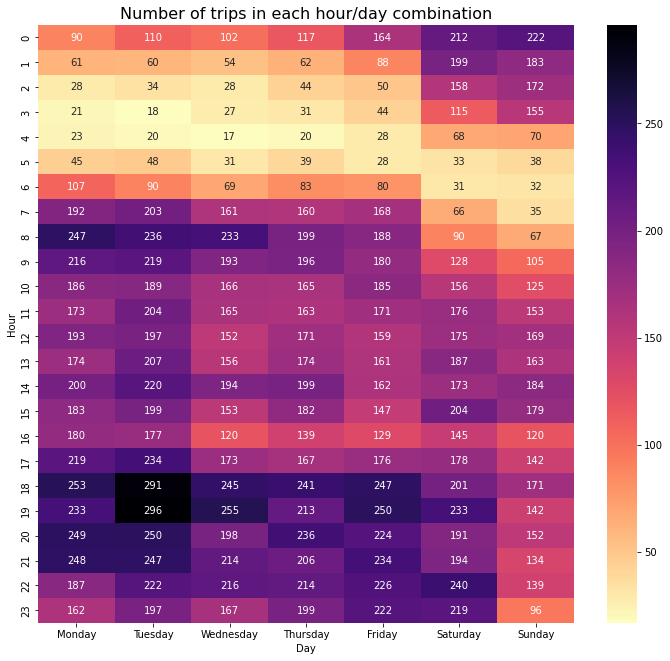

In [84]:
heatmap_activity

Now let's take a look at areas within NYC where there are a lot of potential passengers:

In [85]:
fig=Figure(width=800,height=500)
m = folium.Map(
    location=[(NYC_LAT_LIMITS[0] + NYC_LAT_LIMITS[1])/2, (NYC_LONG_LIMITS[0] + NYC_LONG_LIMITS[1])/2],
    zoom_start=12,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False

)
# weekday morning
START_HOUR = 8
END_HOUR = 10
_df = df.loc[(df["start_hour"].isin(range(START_HOUR,END_HOUR+1))) & (df["day"].isin(set(DAYS) - {"Saturday", "Sunday"}))]


# add 10 rectangles that indicate the most active geohashes in the specified time periods:
gh_df = _df.groupby("start_gh").size()
gh_df.sort_values(ascending = False, inplace = True)
gh_df = gh_df.head(10)
for ghash, n_trips in zip (gh_df.index, gh_df):
    gh_limits = gh.bbox(ghash) 
    bounds = [(gh_limits["n"], gh_limits["w"]),
              (gh_limits["s"], gh_limits["w"]),
              (gh_limits["n"], gh_limits["e"]),
              (gh_limits["s"], gh_limits["e"])]
        # main map
    folium.Rectangle(bounds=bounds, color="#572a27", fill=True, fill_color="#f2e1f1", fill_opacity=n_trips/gh_df.max()).add_to(m)
    fig.add_child(m)
        
# add cluster points
coordinate_list = _df[["start_lat", "start_long"]].values.tolist() + _df[["end_lat", "end_long"]].values.tolist() 
m.add_child(FastMarkerCluster(coordinate_list))

fig


In [86]:
fig=Figure(width=800,height=500)
m = folium.Map(
    location=[(NYC_LAT_LIMITS[0] + NYC_LAT_LIMITS[1])/2, (NYC_LONG_LIMITS[0] + NYC_LONG_LIMITS[1])/2],
    zoom_start=12,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False

)
# weekday evening
START_HOUR = 19
END_HOUR = 23
_df = df.loc[(df["start_hour"].isin(range(START_HOUR,END_HOUR+1))) & (df["day"].isin(set(DAYS) - {"Saturday", "Sunday"}))]


# add 10 rectangles that indicate the most active geohashes in the specified time periods:
gh_df = _df.groupby("start_gh").size()
gh_df.sort_values(ascending = False, inplace = True)
gh_df = gh_df.head(10)
for ghash, n_trips in zip (gh_df.index, gh_df):
    gh_limits = gh.bbox(ghash) 
    bounds = [(gh_limits["n"], gh_limits["w"]),
              (gh_limits["s"], gh_limits["w"]),
              (gh_limits["n"], gh_limits["e"]),
              (gh_limits["s"], gh_limits["e"])]
        # main map
    folium.Rectangle(bounds=bounds, color="#572a27", fill=True, fill_color="#f2e1f1", fill_opacity=n_trips/gh_df.max()).add_to(m)
    fig.add_child(m)
        
# add cluster points
coordinate_list = _df[["start_lat", "start_long"]].values.tolist() + _df[["end_lat", "end_long"]].values.tolist() 
m.add_child(FastMarkerCluster(coordinate_list))

fig

The answer to the questions:

<font color = "green">
    
1. If you were a taxi owner, how would you maximize your earnings in a day?

</font>


- I will ensure that my working hours are sometime between 6 h - 23 h on weekdays, preferably including the evening. This is when most pick-ups take place.
- In all time windows, the area directly to the South of the Central Park is always a hotspot for pick-ups. If I don't have a passenger, I will spend my time circling in this area or waiting in the taxi stand.


<font color = "green">
    
2. If you were a taxi owner, how would you minimize your work time?
    
</font>

My answer to this question is similar to my answer in the first question.

I would minimize my work time by setting my working periods in the evening, starting from the end-of-day rush hour (17 h) until late evening (23 h). I will circle around Central Manhattan as mentioned before.

I would especially avoid the early morning hours (i.e. 2 am - 5 am) on weekdays because the demand for taxis is very low at these times. 


<font color = "green">
    
3. If you run a taxi company with 10 taxis, how would you maximize your earnings?
</font>

Again, my answer will be similar to the above answers. 

Assuming that (1) my taxis can be driven all day long and that (2) the average per-hour salary I have to pay my drivers is lower than the expected earning within that time window, I will have the taxis driven 24/7 and will isntruct the drivers to circle around the most popular pickup and dropoff locations in Central Manhattan.

The size of the fleet is small enough that the intra-company competition will be negligible. 

If the taxis need to be serviced, I will ensure that the taxis are serviced in the least profitable hours, such as early weekday mornings (i.e. 2 am - 5 am), or, if this is not possible, before 9 am on Sunday. 

